# mobilenet
- https://pytorch.org/hub/pytorch_vision_mobilenet_v2/

## transfer learning
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(90),
#         transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
#         transforms.RandomRotation(90),
#         transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'sample': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(90),
#         transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),    
}

data_dir = 'img4'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

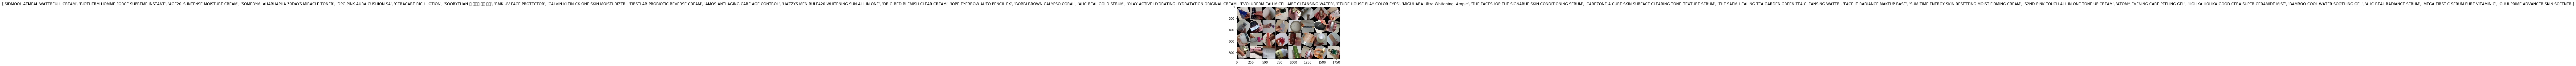

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, save_path, pos=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # ------------------------
                if pos==True:
                    pos_len = 6
                    cls = np.random.randint(0,len(image_datasets['train'].classes))
                    all_targets = np.array(list(zip(range(len(image_datasets['train'].targets)), image_datasets['train'].targets)))
                    all_targets = all_targets[all_targets[:,1]==cls]
                    np.random.shuffle(all_targets)
                    sampled_indics = all_targets[:pos_len, 0]
                    sampled_targets = torch.tensor(all_targets[:pos_len, 1]).to(device).long()
                    sampled_inputs = torch.stack([data_transforms['sample'](image_datasets['train'][i][0])
                                                  for i in sampled_indics]).to(device)
                    inputs = torch.cat([inputs, sampled_inputs])
                    labels = torch.cat([labels, sampled_targets])
                # ------------------------

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # mini batch statistics
                if idx%50==0:
                    print('[batch loss] {} Loss: {:.4f} Acc: {:.4f}'.format(
                        phase, loss, torch.sum(preds == labels.data)/inputs.shape[0]))

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        #save all model every epoch
        PATH = save_path+str(epoch)+'.pt'
        torch.save(model, PATH)
        print('***** Model saved:', PATH, '*****')
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 모델 설정

In [11]:
"""
resnet18 전체 파라미터 재훈련
"""
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [41]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4286 Acc: 0.9635
val Loss: 0.5565 Acc: 0.9265

Epoch 1/24
----------
train Loss: 0.4342 Acc: 0.9601
val Loss: 0.5570 Acc: 0.9265

Epoch 2/24
----------
train Loss: 0.4191 Acc: 0.9635
val Loss: 0.5579 Acc: 0.9265

Epoch 3/24
----------
train Loss: 0.4258 Acc: 0.9734
val Loss: 0.5589 Acc: 0.9265

Epoch 4/24
----------
train Loss: 0.4333 Acc: 0.9668
val Loss: 0.5581 Acc: 0.9265

Epoch 5/24
----------
train Loss: 0.4237 Acc: 0.9701
val Loss: 0.5590 Acc: 0.9265

Epoch 6/24
----------
train Loss: 0.4182 Acc: 0.9635
val Loss: 0.5587 Acc: 0.9265

Epoch 7/24
----------
train Loss: 0.4251 Acc: 0.9734
val Loss: 0.5595 Acc: 0.9265

Epoch 8/24
----------
train Loss: 0.4285 Acc: 0.9701
val Loss: 0.5580 Acc: 0.9265

Epoch 9/24
----------
train Loss: 0.4356 Acc: 0.9568
val Loss: 0.5580 Acc: 0.9265

Epoch 10/24
----------
train Loss: 0.4387 Acc: 0.9635
val Loss: 0.5579 Acc: 0.9265

Epoch 11/24
----------
train Loss: 0.4313 Acc: 0.9701
val Loss: 0.5580 Acc: 0.9265

Ep

In [51]:
"""
resnet18 마지막 피처 파라미터만 재훈련
"""
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [52]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.1997 Acc: 0.0997
val Loss: 2.0810 Acc: 0.1471

Epoch 1/24
----------
train Loss: 1.9919 Acc: 0.3090
val Loss: 1.7934 Acc: 0.4853

Epoch 2/24
----------
train Loss: 1.7442 Acc: 0.5449
val Loss: 1.5221 Acc: 0.5735

Epoch 3/24
----------
train Loss: 1.4618 Acc: 0.6512
val Loss: 1.2652 Acc: 0.7353

Epoch 4/24
----------
train Loss: 1.2193 Acc: 0.8106
val Loss: 1.0518 Acc: 0.8382

Epoch 5/24
----------
train Loss: 1.0064 Acc: 0.9136
val Loss: 0.8809 Acc: 0.8971

Epoch 6/24
----------
train Loss: 0.8728 Acc: 0.9103
val Loss: 0.8688 Acc: 0.8971

Epoch 7/24
----------
train Loss: 0.8740 Acc: 0.9203
val Loss: 0.8548 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.8496 Acc: 0.9236
val Loss: 0.8430 Acc: 0.8971

Epoch 9/24
----------
train Loss: 0.8393 Acc: 0.9136
val Loss: 0.8302 Acc: 0.8971

Epoch 10/24
----------
train Loss: 0.8222 Acc: 0.9302
val Loss: 0.8175 Acc: 0.9118

Epoch 11/24
----------
train Loss: 0.8069 Acc: 0.9402
val Loss: 0.8083 Acc: 0.8971

Ep

In [7]:
"""
mobilenet 전체 파라미터 재훈련
"""
model_mb = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)

# for param in model_mb.parameters():
#     param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_mb.classifier[1] = nn.Linear(1280, len(class_names))
model_mb = model_mb.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_mb = optim.SGD(model_mb.classifier.parameters(), lr=0.001, momentum=0.9)
optimizer_mb = torch.optim.Adam(model_mb.parameters(), lr=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_mb, step_size=7, gamma=0.1)

Using cache found in C:\Users\LSW/.cache\torch\hub\pytorch_vision_master


In [5]:
"""
mobilenet 마지막 피처 파라미터만 재훈련
"""
model_mb = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)

for param in model_mb.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_mb.classifier[1] = nn.Linear(1280, len(class_names))
model_mb = model_mb.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_mb = optim.SGD(model_mb.classifier.parameters(), lr=0.001, momentum=0.9)
optimizer_mb = torch.optim.Adam(model_mb.classifier.parameters(), lr=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_mb, step_size=7, gamma=0.1)

Using cache found in C:\Users\LSW/.cache\torch\hub\pytorch_vision_master


In [8]:
"""
https://pytorch.org/docs/stable/nn.html
mobilenet L2 margin loss, 전체 파라미터 재훈련
"""
class Flatten(torch.nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(Flatten, self).__init__()    
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    
model_mb = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
for param in model_mb.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_mb.classifier[1] = nn.Linear(1280, 2560)
model_mb = model_mb.to(device)

# modules = list(model_mb.children())[:-1]
# avg_pool = torch.nn.AvgPool2d(7, stride=1)
# flatten = Flatten()
# model_mb = torch.nn.Sequential(*modules, avg_pool, flatten) #1280
# model_mb = model_mb.to(device)

# criterion = torch.nn.CosineEmbeddingLoss(margin=0.3, reduction='mean')
criterion = torch.nn.MultiMarginLoss(p=2, margin=3.0, reduction='mean')

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_mb = optim.SGD(model_mb.classifier.parameters(), lr=0.001, momentum=0.9)
optimizer_mb = torch.optim.Adam(model_mb.parameters(), lr=0.005)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_mb, step_size=5, gamma=0.5)

Using cache found in C:\Users\LSW/.cache\torch\hub\pytorch_vision_master


In [9]:
model_mb = train_model(model_mb, criterion, optimizer_mb, exp_lr_scheduler, num_epochs=50, 
                       save_path='torch_models/complex/mobile-b-10-all-margin-', pos=False)

Epoch 0/49
----------
[batch loss] train Loss: 8.6219 Acc: 0.0000
[batch loss] train Loss: 196.4194 Acc: 0.0000
[batch loss] train Loss: 245.7546 Acc: 0.0000
[batch loss] train Loss: 223.4462 Acc: 0.0000
[batch loss] train Loss: 278.8053 Acc: 0.0000
[batch loss] train Loss: 159.1716 Acc: 0.0000
[batch loss] train Loss: 82.7840 Acc: 0.0000
[batch loss] train Loss: 82.8593 Acc: 0.0000
[batch loss] train Loss: 83.6470 Acc: 0.0000
[batch loss] train Loss: 73.9627 Acc: 0.0000
[batch loss] train Loss: 78.0574 Acc: 0.0000
[batch loss] train Loss: 21.2959 Acc: 0.0000
[batch loss] train Loss: 86.5891 Acc: 0.0000
[batch loss] train Loss: 90.1388 Acc: 0.0000
[batch loss] train Loss: 9.8780 Acc: 0.0000
[batch loss] train Loss: 9.1946 Acc: 0.0000
[batch loss] train Loss: 3.2591 Acc: 0.0000
[batch loss] train Loss: 4.9322 Acc: 0.0000
[batch loss] train Loss: 2.8779 Acc: 0.0000
[batch loss] train Loss: 12.9296 Acc: 0.0000
train Loss: 82.2155 Acc: 0.0281
[batch loss] val Loss: 2.0058 Acc: 0.0000
[batc

[batch loss] train Loss: 6.7473 Acc: 0.0000
[batch loss] train Loss: 2.9144 Acc: 0.0000
[batch loss] train Loss: 1.1526 Acc: 0.0000
[batch loss] train Loss: 5.2160 Acc: 0.0000
[batch loss] train Loss: 1.4715 Acc: 0.0000
[batch loss] train Loss: 2.2657 Acc: 0.0000
[batch loss] train Loss: 5.2787 Acc: 0.0000
[batch loss] train Loss: 5.7716 Acc: 0.0000
[batch loss] train Loss: 2.0386 Acc: 0.0000
[batch loss] train Loss: 1.2325 Acc: 0.0000
[batch loss] train Loss: 3.3651 Acc: 0.0000
[batch loss] train Loss: 1.6920 Acc: 0.0000
[batch loss] train Loss: 2.1239 Acc: 0.0000
train Loss: 3.7828 Acc: 0.1565
[batch loss] val Loss: 2.9000 Acc: 0.0000
[batch loss] val Loss: 2.8766 Acc: 0.0000
val Loss: 3.9776 Acc: 0.1369
***** Model saved: torch_models/complex/mobile-b-10-all-margin-7.pt *****
Epoch 8/49
----------
[batch loss] train Loss: 11.8912 Acc: 0.0000
[batch loss] train Loss: 1.4388 Acc: 0.0000
[batch loss] train Loss: 6.1536 Acc: 0.0000
[batch loss] train Loss: 5.9302 Acc: 0.0000
[batch loss

[batch loss] val Loss: 1.2597 Acc: 0.0000
val Loss: 2.5603 Acc: 0.3397
***** Model saved: torch_models/complex/mobile-b-10-all-margin-21.pt *****
Epoch 22/49
----------
[batch loss] train Loss: 2.6525 Acc: 0.0000
[batch loss] train Loss: 1.1456 Acc: 0.0000
[batch loss] train Loss: 2.1055 Acc: 0.0000
[batch loss] train Loss: 0.8869 Acc: 0.0000
[batch loss] train Loss: 1.0934 Acc: 0.0000
[batch loss] train Loss: 3.2059 Acc: 0.0000
[batch loss] train Loss: 2.2351 Acc: 0.0000
[batch loss] train Loss: 7.4182 Acc: 0.0000
[batch loss] train Loss: 3.3842 Acc: 0.0000
[batch loss] train Loss: 1.3034 Acc: 0.0000
[batch loss] train Loss: 4.1559 Acc: 0.0000
[batch loss] train Loss: 0.9562 Acc: 0.0000
[batch loss] train Loss: 0.2139 Acc: 0.0000
[batch loss] train Loss: 2.4498 Acc: 0.0000
[batch loss] train Loss: 4.7370 Acc: 0.0000
[batch loss] train Loss: 1.7046 Acc: 0.0000
[batch loss] train Loss: 9.9144 Acc: 0.0000
[batch loss] train Loss: 2.0912 Acc: 0.0000
[batch loss] train Loss: 1.9290 Acc: 0.

[batch loss] train Loss: 0.3951 Acc: 0.0000
[batch loss] train Loss: 2.4150 Acc: 0.0000
[batch loss] train Loss: 5.0293 Acc: 0.0000
[batch loss] train Loss: 0.4907 Acc: 0.0000
[batch loss] train Loss: 0.5293 Acc: 0.0000
[batch loss] train Loss: 7.0241 Acc: 0.0000
[batch loss] train Loss: 4.1163 Acc: 0.0000
[batch loss] train Loss: 2.2526 Acc: 0.0000
[batch loss] train Loss: 0.2610 Acc: 0.0000
[batch loss] train Loss: 2.7370 Acc: 0.0000
train Loss: 1.9332 Acc: 0.4672
[batch loss] val Loss: 10.0440 Acc: 0.0000
[batch loss] val Loss: 0.3926 Acc: 0.0000
val Loss: 2.2869 Acc: 0.3922
***** Model saved: torch_models/complex/mobile-b-10-all-margin-36.pt *****
Epoch 37/49
----------
[batch loss] train Loss: 1.2875 Acc: 0.0000
[batch loss] train Loss: 3.8533 Acc: 0.0000
[batch loss] train Loss: 0.3389 Acc: 0.0000
[batch loss] train Loss: 3.6196 Acc: 0.0000
[batch loss] train Loss: 2.6319 Acc: 0.0000
[batch loss] train Loss: 1.8093 Acc: 0.0000
[batch loss] train Loss: 1.0363 Acc: 0.0000
[batch lo

In [17]:
model_mb = train_dmn(model_mb, criterion, optimizer_mb, exp_lr_scheduler,
                     num_epochs=50, save_path='torch_models/mobile-b-10-all-cos-')

Epoch 0/19
----------
[batch loss] train Loss: 0.2940
[batch loss] train Loss: 0.0160
[batch loss] train Loss: 0.0295
[batch loss] train Loss: 0.0301
[batch loss] train Loss: 0.1213
[batch loss] train Loss: 0.0090
[batch loss] train Loss: 0.0032
[batch loss] train Loss: 0.0503
[batch loss] train Loss: 0.0013
[batch loss] train Loss: 0.0456
[batch loss] train Loss: 0.0991
train Loss: 0.0321
val Loss: 0.1415


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


***** Model saved: torch_models/mobile-b-10-all-cos-0.pt *****
Epoch 1/19
----------
[batch loss] train Loss: 0.1523
[batch loss] train Loss: 0.0332
[batch loss] train Loss: 0.0424
[batch loss] train Loss: 0.0058
[batch loss] train Loss: 0.0578
[batch loss] train Loss: 0.0000
[batch loss] train Loss: 0.0124
[batch loss] train Loss: 0.0049
[batch loss] train Loss: 0.0232
[batch loss] train Loss: 0.0005
[batch loss] train Loss: 0.0012
train Loss: 0.0240
val Loss: 0.1697
***** Model saved: torch_models/mobile-b-10-all-cos-1.pt *****
Epoch 2/19
----------
[batch loss] train Loss: 0.0125
[batch loss] train Loss: 0.0000
[batch loss] train Loss: 0.0085
[batch loss] train Loss: 0.0378
[batch loss] train Loss: 0.1643
[batch loss] train Loss: 0.0010
[batch loss] train Loss: 0.0000
[batch loss] train Loss: 0.0000
[batch loss] train Loss: 0.0000
[batch loss] train Loss: 0.0000
[batch loss] train Loss: 0.0201
train Loss: 0.0174
val Loss: 0.0641
***** Model saved: torch_models/mobile-b-10-all-cos-2.

---
# siamese net

In [14]:
def batch_pair_loader(dataset, n_batch=64, pos_ratio=0.02):
    """
    make random pairs minibatch for siamese network margin loss
    @param dataset: torch dataset
    @param n_batch: number of mini batch
    @param pos_ratio: 
    """
    # [[idx_orig, target], [idx_orig, target]...]
    all_targets = np.array(list(zip(range(len(dataset.targets)), dataset.targets)))
    # 클래스 랜덤 샘플
    cls_batch = np.random.randint(0, len(dataset.classes), size=n_batch) # replace samping
    # positive 랜덤 인덱스 페어 생성
    _neg_firts_idx = int(n_batch*pos_ratio)
    first_list = []
    second_list = []
    # positive sampling
    for cls in cls_batch[:_neg_firts_idx]:
        cls_targets = all_targets[all_targets[:,1]==cls]
        i1, i2 = np.random.choice(cls_targets[:,0], 2, replace=True)
        first_list.append(i1)
        second_list.append(i2)
    # negative sampling
    for cls in cls_batch[_neg_firts_idx:]:
        cls_targets = all_targets[all_targets[:,1]==cls]
        cls_targets_neg = all_targets[all_targets[:,1]!=cls]
        i1 = np.random.choice(cls_targets[:,0], 1, replace=True)
        i2 = np.random.choice(cls_targets_neg[:,0], 1, replace=True)        
        first_list.append(int(i1))
        second_list.append(int(i2))    
    
    label = [1]*_neg_firts_idx + [-1]*(n_batch-_neg_firts_idx)
    label = np.array(label)
    # x1, x2, targets
    # dataloader 거치는 것이 아니므로 data_transforms 직접 해줘야함
    x1s = torch.stack([data_transforms['sample'](dataset[i][0]) for i in first_list])
    x2s = torch.stack([data_transforms['sample'](dataset[i][0]) for i in second_list])
    return x1s, x2s, label, cls_batch

In [18]:
def train_dmn(model, criterion, optimizer, scheduler, num_epochs, save_path):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            n_batch = {'train':32, 'val':5}
            n_iter_per_epoch = int(len(image_datasets[phase])/n_batch[phase])
            if phase=='val': n_iter_per_epoch = 5
            for idx in range(n_iter_per_epoch):
                # for idx, (inputs, labels) in enumerate(dataloaders[phase]):
                x1s, x2s, labels, _ = batch_pair_loader(image_datasets[phase], n_batch=n_batch[phase])
                x1s = x1s.to(device)
                x2s = x2s.to(device)
                labels = torch.tensor(labels).float().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs1 = model(x1s)
                    outputs2 = model(x2s)
                    # _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs1, outputs2, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # mini batch statistics - 10 times per epoch
                if phase=='train' and idx % (n_iter_per_epoch//10) == 0:
                    print('[batch loss] {} Loss: {:.4f}'.format(phase, loss))

                # statistics
                running_loss += loss * n_batch[phase]

            # epoch 의미가 없음 랜덤 샘플링이라
            epoch_loss = running_loss / n_batch[phase] / n_iter_per_epoch
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss > best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        #save all model every epoch
        PATH = save_path+str(epoch)+'.pt'
        torch.save(model, PATH)
        print('***** Model saved:', PATH, '*****')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [35]:
"""
import torch
import numpy as np
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    """ Diabetes dataset."""

    # Initialize your data, download, etc.
    def __init__(self):
        xy = np.loadtxt('./reference_means2.csv',
                        delimiter=',')#, dtype=np.float32)
        self.len = xy.shape[0]
        self.x_data = torch.from_numpy(xy[:, :-1])
        self.y_data = torch.from_numpy(xy[:, -1])

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = MyDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=8,
                          shuffle=True,
                          num_workers=0)

"""

---
# visualize

In [55]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
#                 print(class_names[labels[j]])
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[ans]: {}, // [predicted]: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

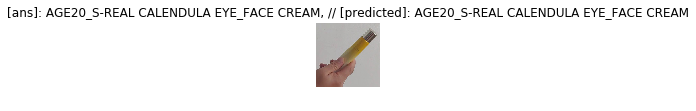

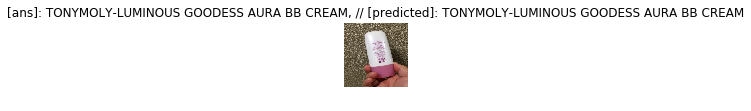

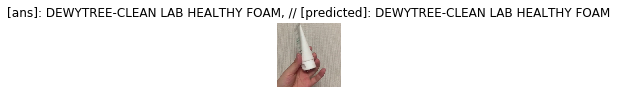

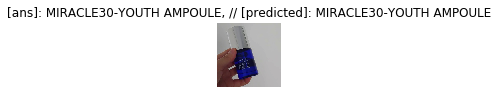

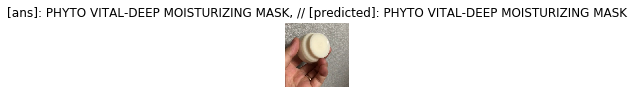

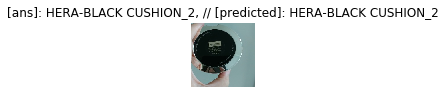

In [86]:
visualize_model(model_mb)

---
## Model save / load
- https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [7]:
PATH = 'torch_models/mobile-b-10-all-cos-'+str(epoch)+'.pt'
torch.save(model_mb, PATH)

'torch_models/mobile-b-10-all-cos1.pt'

In [39]:
# PATH = 'torch_models/mobile-b-10-all-rot2.pt'
PATH = 'torch_models/mobile-b-10-all-cos.pt'

# torch.save(model_ft.state_dict(), PATH)
torch.save(model_mb, PATH)

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [40]:
modules = list(model2.children())[:-1]
linear = torch.nn.Linear(1280, 1000)
avg_pool = torch.nn.AvgPool2d(7, stride=1)
m3 = torch.nn.Sequential(*modules, avg_pool)

In [43]:
m3.cuda()
m3.eval()
m3(torch.rand([1,3,224,224]).cuda()).view(-1,1280).shape

torch.Size([1, 1280])

In [4]:
model2 = torch.load(PATH)
model2.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_

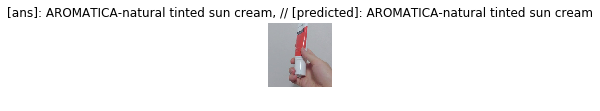

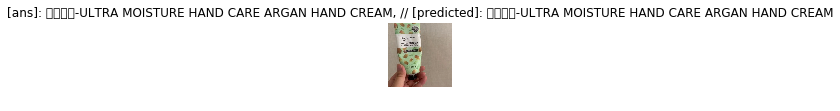

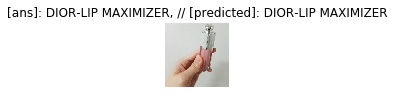

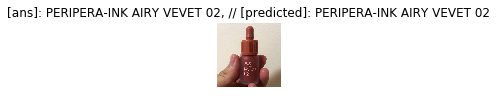

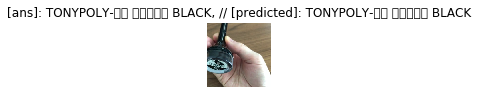

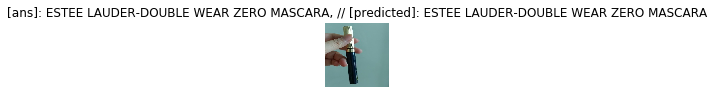

In [90]:
visualize_model(model2)

---
## data preprocesing
 - 9:1로 train/
val나누기

In [24]:
"""# 논문 재현용 데이터 레이블 만들기 코드
import torch, torchvision

reference_dataset = torchvision.datasets.ImageFolder(root='./img4/train')

with open("train.txt", 'w', encoding='utf8') as f:
    for i in reference_dataset.imgs:
        f.write(i[0][7:]+'\t'+str(i[1])+'\n')"""

In [16]:
"""
ms loss용 데이터 만들기
"""
from glob import glob
from tqdm import tqdm_notebook as tqdm
import os
import subprocess

data_dir = 'data\\Stanford_Online_Products'
data_dir_new = 'productImg'

cls2idx = {e:i for i,e in enumerate(os.listdir(data_dir))}
train_txt = open(os.path.join(data_dir_new, "train.txt"), 'w', encoding='utf8')
test_txt = open(os.path.join(data_dir_new, "test.txt"), 'w', encoding='utf8')
        
for d in os.listdir(data_dir):
    for idx, fn in tqdm(enumerate(glob(os.path.join(data_dir, d, '*.jpg')))):
        if idx>0 and idx%10==0:
            if not os.path.isdir(os.path.join(data_dir_new, 'val', d)):
                os.mkdir(os.path.join(data_dir_new, 'val', d))
            new_fn = os.path.join(data_dir_new, 'val', d, os.path.split(fn)[-1])
            command = ['cmd', '\/c', 'copy',  fn , new_fn]
            test_txt.write(os.path.join(new_fn)+'\t'+str(cls2idx[d])+'\n')
        else:
            if not os.path.isdir(os.path.join(data_dir_new, 'train', d)):
                os.mkdir(os.path.join(data_dir_new, 'train', d))            
            new_fn = os.path.join(data_dir_new, 'train', d, os.path.split(fn)[-1])
            command = ['cmd', '\/c', 'copy',  fn , new_fn]
            train_txt.write(os.path.join(new_fn)+'\t'+str(cls2idx[d])+'\n')
            
        subprocess.check_output(command)
    print(d)
    
train_txt.close()
test_txt.close()

A Jupyter Widget

Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




bicycle_final


A Jupyter Widget


cabinet_final


A Jupyter Widget


chair_final


A Jupyter Widget


coffee_maker_final


A Jupyter Widget


fan_final


A Jupyter Widget


kettle_final


A Jupyter Widget


lamp_final


A Jupyter Widget


mug_final


A Jupyter Widget


sofa_final


A Jupyter Widget


stapler_final


A Jupyter Widget


table_final


A Jupyter Widget


toaster_final


In [329]:
from glob import glob
from tqdm import tqdm_notebook as tqdm
import os
import subprocess

data_dir = 'img_real\\backbone'
data_dir_new = 'img4'

for d in os.listdir(data_dir):
    for idx, fn in tqdm(enumerate(glob(os.path.join(data_dir, d, '*.jpg')))):
        if idx>0 and idx%10==0:
            if not os.path.isdir(os.path.join(data_dir_new, 'val', d)):
                os.mkdir(os.path.join(data_dir_new, 'val', d))
            command = ['cmd', '\/c', 'copy',  fn , os.path.join(data_dir_new, 'val', d, os.path.split(fn)[-1])]
        else:
            if not os.path.isdir(os.path.join(data_dir_new, 'train', d)):
                os.mkdir(os.path.join(data_dir_new, 'train', d))            
            command = ['cmd', '\/c', 'copy',  fn , os.path.join(data_dir_new, 'train', d, os.path.split(fn)[-1])]
            
        subprocess.check_output(command)
    print(d)

A Jupyter Widget


1MILLION-PERFUME


A Jupyter Widget


4GF-SUPER PURE CLEAR GEL


A Jupyter Widget


6GF+-PROTEOGLYCAN SKIN CARE CREAM


A Jupyter Widget


6XCREAM-TREATROMM 6 CREAM


A Jupyter Widget


9WISHES-HYDRA AMPULE SERUM


A Jupyter Widget


A DERMA-PHYS AC PURIFYING FOAMING GEL


A Jupyter Widget


A2H-CURL UP ESSENCE


A Jupyter Widget


ABLE C_C-미샤M 비비 부머


A Jupyter Widget


ACAI BERRY-MICELLAR CLEANSING FACE SCRUB GEL


A Jupyter Widget


ACNES-CLEAR_WHITE FOAMING WASH


A Jupyter Widget


ACNES-DERMA RELIEF ESSENCE LOTION


A Jupyter Widget


ACURE-THE ESSENTIALS MOROCCAN ARGAN OIL


A Jupyter Widget


ACWELL-AQUA CLINITY CREAM


A Jupyter Widget


AESTURA-ATOBARRIER365


A Jupyter Widget


AGE20_S-AURORA ESSENTIAL CREAM


A Jupyter Widget


AGE20_S-CELL BOUNCE CONCENTRATED SERUM


A Jupyter Widget


AGE20_S-ESSENCE COVER FACT VX


A Jupyter Widget


AGE20_S-HYDRA SYNERGY CREAM


A Jupyter Widget


AGE20_S-INTENSE MOISTURE CREAM


A Jupyter Widget


AGE20_S-REAL CALENDULA EYE_FACE CREAM


A Jupyter Widget


AGE20_S-ULTRA MOISTURE ESSENCE


A Jupyter Widget


AGE20_S-에센스 쿠션


A Jupyter Widget


AHC-Aura Secret Toneup Cream


A Jupyter Widget


AHC-Capture Hyaluronic


A Jupyter Widget


AHC-Natural Vita Sun Stick


A Jupyter Widget


AHC-NATURE PLUS SUNSTIC


A Jupyter Widget


AHC-ONLY FOR MAN LOTION


A Jupyter Widget


AHC-PERFECT DUAL COVER CUSHION 23


A Jupyter Widget


AHC-REAL ACTIVE BLENDING CREAM


A Jupyter Widget


AHC-REAL ACTIVE PERFECTION CREAM


A Jupyter Widget


AHC-REAL GOLD SERUM


A Jupyter Widget


AHC-REAL RADIANCE SERUM


A Jupyter Widget


AHC-REAL SYNERGY OIL


A Jupyter Widget


AHC-THE REAL EYE CREAM FOR FACE


A Jupyter Widget


AHC-ULTIMATE REAL EYE CREAM FOR FACE


A Jupyter Widget


AHC-VITAL BLACK SEED TONER


A Jupyter Widget


ALGOLOGIE-RICHESSE DES VAGUES


A Jupyter Widget


ALOE VERA-ALOE MOISTURIZING BRIGHT CARE


A Jupyter Widget


ALPECIN-COFFEIN SHAMPOO


A Jupyter Widget


AMOREPACIFIC-CONTOURE LIFT SKIN DEFINING CREME


A Jupyter Widget


AMOS-AGE CONTROL SAMPOO


A Jupyter Widget


AMOS-ANTI AGING CARE AGE CONTROL


A Jupyter Widget


AMOS-REPAIR FORCE THERAPY ESSENTIAL OIL


A Jupyter Widget


ANDALOUS NATURALS-AGE DEFYING NIGHT REPAIR CREAM


A Jupyter Widget


ANESSA-AQUA BOOSTER


A Jupyter Widget


ANNASUI-PERFUME


A Jupyter Widget


APIEU-POWER BLOCK SUN BASE


A Jupyter Widget


APIEU-PURE BLOCK


A Jupyter Widget


AQUAVELVA-Sensitive 5 in 1 after shave balm


A Jupyter Widget


AQUAXL-MAKE UP FOR EVER


A Jupyter Widget


ARITAUM-SUGARBALL VELVET CHEEK COLOR


A Jupyter Widget


AROMATICA-ALOW MINERAL SUNSCREEN


A Jupyter Widget


AROMATICA-natural tinted sun cream


A Jupyter Widget


ASIS TOBE-Hyaluronic Essential Toner


A Jupyter Widget


ATOMY-EVENING CARE PEELING GEL


A Jupyter Widget


ATOMY-SKIN CARE SYSTEM THE FAME LOTION


A Jupyter Widget


ATOMY-Sunscreen SPF 50+ PA+++


A Jupyter Widget


ATOPALM-MOISTURE BALANCING CREAM


A Jupyter Widget


ATOPALM-SOOTHING GEL LOTION


A Jupyter Widget


ATOPALM-TOP TO TOE WASH


A Jupyter Widget


AVEDA-BOTANICAL KINETICS HYDRORATING LOTION


A Jupyter Widget


AVEDA-DAMAGE REMEDY


A Jupyter Widget


AVEENO-DAILY MOISTURIZING


A Jupyter Widget


AVENE-EAU THERMAL MIST


A Jupyter Widget


A_PIEU-MINERAL MONO SHADOW


A Jupyter Widget


A_PIEU-POWER BLOCK SUN BASE


A Jupyter Widget


BAMBOO-COOL WATER SOOTHING GEL


A Jupyter Widget


BANANABOAT-ALOE VERA GEL


A Jupyter Widget


BANILACO-프라임 프라이머 클래식


A Jupyter Widget


BATH_BODY WORKS-HELLO BEAUTIFUL ULTRA SHEA BODY CREAM


A Jupyter Widget


BATH_BODY WORKS-PRETTY AS A PEACH BODY LOTION


A Jupyter Widget


BATH_BODY WORKS-SUPER SOFT BODY BUTTER SHEA BUTTER COCONUT OIL


A Jupyter Widget


BEAUTYMORY-CRYSTAL EXPERT BB CREAM


A Jupyter Widget


BELIF-BELIEVE IN TRUTH CREAM


A Jupyter Widget


BELIF-BERGAMOT HERBAL EXTRACT TONER


A Jupyter Widget


BELIF-CREAMY MOISTURIZER DEEP MOIST


A Jupyter Widget


BELIF-MANOLOGY MOISTURIZER AQUA BOMB


A Jupyter Widget


BELIF-STRESS SHOOTER CICA BOMB CREAM


A Jupyter Widget


BELIF-THE TRUE CREAM AQUA BOMB


A Jupyter Widget


BELIF-THE TRUE CREAM MOISTURIZING BOMB


A Jupyter Widget


BELIF-UV PROTECTOR DAILY SUNSCREEN GEL


A Jupyter Widget


BENEFIC-CHA CHA TINT


A Jupyter Widget


BENEFIC-DANDELION BLUSHER


A Jupyter Widget


BENEFIC-HIGH BEAM


A Jupyter Widget


BENEFIC-SUGARBOMB


A Jupyter Widget


BENEFIC-THE PORE FESSIONAL


A Jupyter Widget


BENEFIT-the porefessional pearl primer


A Jupyter Widget


BENIZOIE-MILK BODY LOTION


A Jupyter Widget


BENIZOIE-PERFECT SUN PROTECTOR


A Jupyter Widget


BEVELY HILLS-POLO CLUB JOY


A Jupyter Widget


BEYOND-ANGEL AQUA DAILY CICA CREAM


A Jupyter Widget


BEYOND-ANGEL KIDS BODY LOTION


A Jupyter Widget


BEYOND-ARGAN THERAPY CURLING ESSENCE


A Jupyter Widget


BEYOND-CLASSIC HAND CREAM INTENSIVE TOTAL RECOVERY


A Jupyter Widget


BEYOND-DISNEY ECO CREAM


A Jupyter Widget


BEYOND-HOMME ALL IN ONE FORMULA


A Jupyter Widget


BEYOND-LIFTING MOISTURE THE NUTCRACKER


A Jupyter Widget


BEYOND-OH MY SUN CREAM


A Jupyter Widget


BEYOND-PHYTO AQUA WATER SUN BASE WITH SAP COMPLEX


A Jupyter Widget


BIO OIL-PURECELLIN OIL


A Jupyter Widget


BIODERMA-ATODERM


A Jupyter Widget


BIODERMA-ATODRM PP BAUME ULTRA NOURISHING BALM


A Jupyter Widget


BIODERMA-HYDRABIO CREAM


A Jupyter Widget


BIODERMA-HYDRABIO H2O SOLUTION MICELLAIRE


A Jupyter Widget


BIOSILK-SILK THERAPY ENRICHED ACTION HAIR TREATMENT


A Jupyter Widget


BIOTHERM-Body Refirm Stretch Oil


A Jupyter Widget


BIOTHERM-EAU VITAMINEE PERFUMED BODY MILK


A Jupyter Widget


BIOTHERM-HOMME AQUAPOWER FRESH LOTION IN GEL


A Jupyter Widget


BIOTHERM-HOMME FORCE SUPREME INSTANT


A Jupyter Widget


BIOTHERM-HOMME FORCE SUPREME SERUM


A Jupyter Widget


BLACK BEAN-DASHU BLACK BEAN SUPER HARD SPRAY


A Jupyter Widget


BLACK-LIP STICK


A Jupyter Widget


BLACKMORES-NATURAL VITAMINE E CREAM


A Jupyter Widget


BLGARI-POUR HOMME PERFUME


A Jupyter Widget


BOBBI BROWN-CALYPSO CORAL


A Jupyter Widget


BOBBI BROWN-EYE SHADOW


A Jupyter Widget


BOBBI BROWN-FRESH MELON24


A Jupyter Widget


BOBBI BROWN-Long Water Cream Shadow Stick


A Jupyter Widget


BOBBI BROWN-LONG WEAR EVEN FOUNDATION


A Jupyter Widget


BOBBI BROWN-POT ROUGE FOR LIPS AND CHEEKS


A Jupyter Widget


BOBBI BROWN-PRIMER PLUS PROTECTION


A Jupyter Widget


BONABELLA-ROSE WATER TONE UP CREAM


A Jupyter Widget


BONAMEDUSA-ALPI SNOW CREAM


A Jupyter Widget


BONAMEDUSA-FACE WAVE DELETE


A Jupyter Widget


BONAMEDUSA-FIXER_AMPOULE X MIST


A Jupyter Widget


BONAMEDUSA-ORANGE SKIN DELETE


A Jupyter Widget


BOOTS-cucumber moisturising lotion for a smooth day


A Jupyter Widget


BORMTREE-GOAT MILK TONE UP CREAM


A Jupyter Widget


BOTANITY-FLAVON SERUM


A Jupyter Widget


BRING GREEN-ARTEMISIA CALMING CREAM


A Jupyter Widget


BUBERRY-PERFUME CLASSIC WOMEN


A Jupyter Widget


BURBERRY-WEEKEND FOR MEN MINIATURE PERFUME


A Jupyter Widget


BURBERY-BRIT SHEER PERFUME


A Jupyter Widget


BURT_S BEES-COCONUT FOOT CREAME


A Jupyter Widget


BVLGARI-AQVA ATLANTIQVE


A Jupyter Widget


BVLGARI-BLV POUR HOMME


A Jupyter Widget


BYREDO-ROSE OF NO MANS_S LAND EAU DE PARFUM


A Jupyter Widget


CALVIN KLEIN-CK ONE SKIN MOISTURIZER


A Jupyter Widget


CALVIN KLEIN-CK2 PERFUME


A Jupyter Widget


CANMAKE-PERFECT BROWN EYES


A Jupyter Widget


CAPTURE-REVITE SOLUTION AMPOULE


A Jupyter Widget


CAREZONE-A CURE 13 TROUBLE CALMING CREAM


A Jupyter Widget


CAREZONE-A CURE SKIN SURFACE CLEARING TONE_TEXTURE SERUM


A Jupyter Widget


CAROLINA HERRERA-L_EAU EAU FRAICHE 100ML SPRAY


A Jupyter Widget


CAUDALIE-EAU DE BEAUTE BEAUTY ELIXIR


A Jupyter Widget


CAUDALIE-HUILE DIVINE DIVINE OIL


A Jupyter Widget


CAUDALIE-VINOPERFECT RADIANCE SERUM


A Jupyter Widget


CELIMA-DERMA NATURE FRESh BLACKHEAD JOJOBA CLEANSING OIL


A Jupyter Widget


CELL FUSION C-CURE SUNCREEN 100


A Jupyter Widget


CELLSKIN-RENEWAL DUAL EFFECT SERUM


A Jupyter Widget


CENTELLIAN24-Centellian Madeca Skin Emulsion


A Jupyter Widget


CENTELLIAN24-MADECA CREAM POWER BOOSTING FORMULA


A Jupyter Widget


CENTELLIAN24-MADECA SOLUTION ESSENCE


A Jupyter Widget


CENTELLIAN24-MADECA TONING ESSENCE TREATMENT


A Jupyter Widget


CENTELLIAN24-MADECA UV DEFENCE SUN CUSHION


A Jupyter Widget


CENTELLIAN24-MADECA UV PROTECTION SUN STICK


A Jupyter Widget


CERACARE-RICH LOTION


A Jupyter Widget


CEZANNE-MIX COLOR CHEEK


A Jupyter Widget


CFEAD05F-224D_4DE0_AB61_041FDEF2D19C_junghyuk lee


A Jupyter Widget


CHAMPS ELYSEES-EAU DE TOILETTE GUERLAIN FOR WOMEN


A Jupyter Widget


CHANEL-ALLURE


A Jupyter Widget


CHANEL-COCO MADEMISELLE PERFUME


A Jupyter Widget


CHANEL-COMPLETE CORRECTION CREAM


A Jupyter Widget


CHANEL-DEMAQUILLANT YEUX INTENSE


A Jupyter Widget


CHANEL-INIMITABLE EXTREME MASCARA


A Jupyter Widget


CHANEL-JOUES CONTRASTE


A Jupyter Widget


CHANEL-LE BLANC Light Creator Brightening Makeup Base


A Jupyter Widget


CHANEL-NO5


A Jupyter Widget


CHANEL-POWDER BLUSH 86 DISCREATION


A Jupyter Widget


CHANEL-STYLO EYE LINER


A Jupyter Widget


CHARMZONE-ALBA TROSS DAILY SUN


A Jupyter Widget


CHARMZONE-ANTI_WRINKLE PINK OIL IN SERUM


A Jupyter Widget


CHARMZONE-Control Cream 225g


A Jupyter Widget


CHARMZONE-DeAge CRD_Softening Emulsion


A Jupyter Widget


CHARMZONE-DeAge Red Addition Nutrient Cream


A Jupyter Widget


CHARMZONE-DeAge Red Addition Skin Toner


A Jupyter Widget


CHARMZONE-DeAge Red Edition Eye cream


A Jupyter Widget


CHARMZONE-ROSY VOLUME HEARTZONE CREAM


A Jupyter Widget


CHARMZONE-Top Class Royal Eye Cream


A Jupyter Widget


CHICA Y CHICO-ONE SHOT EYE PALETTE


A Jupyter Widget


CHLOE-EAU DE PERFUME


A Jupyter Widget


CHOSUNGAH-C_T Blend Easy Firming


A Jupyter Widget


CHOSUNGAH-슈퍼 핏 커버 파운데이션 2X 1호


A Jupyter Widget


CLAIRE_S KOREA-GUERISSON 9 COMPLEX


A Jupyter Widget


CLAIRE_S KOREA-GUERISSON MEN_S ONE


A Jupyter Widget


CLAIRE_S KOREA-GUERISSON SIGNATURE OIL SERUM


A Jupyter Widget


CLARINS-EXTRA FIRMING NECK


A Jupyter Widget


CLARINS-SOIN COMPLET


A Jupyter Widget


CLEAN AND CLEAR-페이셜 포밍 클렌저


A Jupyter Widget


CLEAN-WARM COTTON EAU DE PERFUME


A Jupyter Widget


CLINIQUE-BLENDED FACE POWER


A Jupyter Widget


CLINIQUE-CHUBBY STICK MOISTURIZING LIP COLOUR BALM


A Jupyter Widget


CLINIQUE-CLARIFYING MOISTURE LOTION


A Jupyter Widget


CLINIQUE-LIP_EYE MAKEUP PALETTE 5X COLOUR SURGE LIPSTICK


A Jupyter Widget


CLIO-ART SHADOW 17 NIGHT BLUE


A Jupyter Widget


CLIO-KILL BROW AUTO HARD BROW PENCIL 5 GRAY BROWN


A Jupyter Widget


CLIO-ROUSE HEEL NOODIE BROWN


A Jupyter Widget


CLIO-SHARP SO SIMPLE WARTERPROOF PENCIL LINER


A Jupyter Widget


CLIO-VEIGIN KISS SILKUID LIP


A Jupyter Widget


CNP LABORATORY-GREEN PROPOLIES PERFECT WRINKLE CORRECTOR


A Jupyter Widget


CNP LABORATORY-GREEN PROPOLIS ANTI_OXIDANT AMPULE


A Jupyter Widget


CNP LABORATORY-Green Propolis Engery Recharging Emulsion


A Jupyter Widget


CNP LABORATORY-Green Propolis Intense Firming Creem


A Jupyter Widget


CNP LABORATORY-Green Propolis Skin Hydrating Enhancer


A Jupyter Widget


CNP LABORATORY-HOME ACTIVE SUN BB CREAM


A Jupyter Widget


CNP LABORATORY-Tune_sun care up proection sun


A Jupyter Widget


CONAD-CREMA SOLARE VISO


A Jupyter Widget


CONDENSE-BRIGHT AND SOFT LOTION


A Jupyter Widget


COSMEDICS-ULOS


A Jupyter Widget


CREMA IDRALIA-OFFICLNA PROFUMO FARMACEUTLCA


A Jupyter Widget


DAISO-GREENTEA NAIL REMOVER


A Jupyter Widget


DARPHIN-HYDRASKIN RICH CREAM


A Jupyter Widget


DARPHIN-INTREAL TONER


A Jupyter Widget


DERMA B-EVERY DAY SUN BLOCK


A Jupyter Widget


DERMA PLATZ-ACTIVE LAYERED CREAM


A Jupyter Widget


DERMALIFT-CENTELLA REPAIR AMPOULE


A Jupyter Widget


DERMATORY-AZULENE HYPOALLERGENIC CICA CREAM


A Jupyter Widget


DEWYTREE-CLEAN LAB HEALTHY FOAM


A Jupyter Widget


DIOR-ADDICT LIP CLOW


A Jupyter Widget


DIOR-DIORSKIN FOREVER EXTREME CONTROL


A Jupyter Widget


DIOR-LIP MAXIMIZER


A Jupyter Widget


DIOR-ROSE EN


A Jupyter Widget


DMCK-CLEAN AC CREAM SOOTHING COMBINATION


A Jupyter Widget


DOCTORCOS-SNOW WHITE WATER GLOW MASK


A Jupyter Widget


DOLCE_GABBANA-LIGHT BLUE_1


A Jupyter Widget


DOLCE_GABBANA-LIGHT BLUE_2


A Jupyter Widget


DOLCE_GABBANA-THE ONE GENTLEMAN


A Jupyter Widget


DOUBLE RICH-ART DE PEAU HAIR GEL


A Jupyter Widget


DPC-PINK AURA CUSHION SA


A Jupyter Widget


DR.AG PLUS-CICAREPAIR PEELING PAD


A Jupyter Widget


DR.AG PLUS-INTERSIVE DERMA CICA SALVE CREAM


A Jupyter Widget


DR.G-A CLEAR BALANCING MOISTURIZER


A Jupyter Widget


DR.G-AIRY SKIN UP SUN


A Jupyter Widget


DR.G-BRIGHTENING PEELING GEL


A Jupyter Widget


DR.G-BRIGHTENING UP SUN


A Jupyter Widget


DR.G-FILAGRIN BARRIER CREAM


A Jupyter Widget


DR.G-GREEN MILD UP SUN


A Jupyter Widget


DR.G-RED BLEMISH CLEAR CREAM


A Jupyter Widget


DR.JART+-BB BEAUTY BALM


A Jupyter Widget


DR.JART+-HOLY SKIN SOOTHING BALM


A Jupyter Widget


DR.JART-FOUNDATION


A Jupyter Widget


DR.PEPTI+-CENTELLA TONER


A Jupyter Widget


DR.YOUNG-ANTI PORE ERASER BALM


A Jupyter Widget


D_ALBA-WHITE TROUBLE FIRST SPREY SERUM


A Jupyter Widget


E45-DERMATOLOGICAL CREAM


A Jupyter Widget


ECLADO-OIL FREE SUN CREAM


A Jupyter Widget


ECLADO-Real White eRaser Cream


A Jupyter Widget


ECLADO-regene Blemish Balm


A Jupyter Widget


EDP-DOMINIQUE ROPION GERANIUM TOUR MONSIEUR


A Jupyter Widget


ELASTINE-Silk repair recovery oil essence


A Jupyter Widget


ELENSILIA CPP-PLACENTA 80 MILLESIS CREAM


A Jupyter Widget


ELENSILIA-ESCARGOT ORIGINAL REPAIR BEE VENOM MIST


A Jupyter Widget


ELIZABETH ARDEN-EIGHT HOUR CREAM


A Jupyter Widget


ENJOY-Perfect Daily Sun Cream


A Jupyter Widget


ENPRANI-ONE TOUCH SUN POWDER


A Jupyter Widget


ESCADA-HOMME ESSENCE EMULSION


A Jupyter Widget


ESTEE LAUDER-DOUBLE WEAR


A Jupyter Widget


ESTEE LAUDER-DOUBLE WEAR STAY IN PLACE MAKEUP_1


A Jupyter Widget


ESTEE LAUDER-DOUBLE WEAR STAY IN PLACE MAKEUP_2


A Jupyter Widget


ESTEE LAUDER-Double Wear Stay_in_Place Makeyp


A Jupyter Widget


ESTEE LAUDER-DOUBLE WEAR ZERO MASCARA


A Jupyter Widget


ESTEE LAUDER-SUMPTUOUS KNOCKOUT MASCARA


A Jupyter Widget


ESTETICA-HYDRA MULTI THERAPY


A Jupyter Widget


ESTHEMORE-컬링 에센스 2X


A Jupyter Widget


ETUDE HOUSE-DOUBLE LASTING FOUNDATION


A Jupyter Widget


ETUDE HOUSE-GLOW ON BASE


A Jupyter Widget


ETUDE HOUSE-PLAY COLOR EYES


A Jupyter Widget


ETUDE HOUSE-SOON JUNG MOIST RELIEF ALL IN ONE GEL


A Jupyter Widget


ETUDE HOUSE-UV DOUBLE CUT SUN GEL


A Jupyter Widget


EUBOS-HAUT RUHE CREAM


A Jupyter Widget


EUCERIN-DERMATOCLEAN CLARIFYING TONER


A Jupyter Widget


EUCERIN-HYALURON FILLER VOLUME LIFT


A Jupyter Widget


EVAS-LEMONADE MOISTURE HAND CREAM


A Jupyter Widget


EVOLUDERM-EAU MICELLAIRE CLEANSING WATER


A Jupyter Widget


EXCELMAKE-FIVE LAYERS SHADOW


A Jupyter Widget


FACE IT-RADIANCE MAKEUP BASE


A Jupyter Widget


FAIRY TALES-ROSEMARY HAIR SPRAY


A Jupyter Widget


FAISIES-MAYBELINE VOLUME EXPRESS


A Jupyter Widget


FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY


A Jupyter Widget


FERRARI-UOMO PERFUME


A Jupyter Widget


FIRST AID BEAUTY-ULTRA REPAIR CREAM


A Jupyter Widget


FIRSTLAB-PROBIOTIC REVERSE CREAM


A Jupyter Widget


FIXX-ALL DAY GLOW MAKEUP SETTING


A Jupyter Widget


FO ARUM-NATURAL BB CREAM


A Jupyter Widget


FRESH-SUGAR FACE POLISH


A Jupyter Widget


FROM NATURE-ALOEVERA PERFECT SUN BLOCK


A Jupyter Widget


FROM NATURE-COLLAGEN HYDRO HONEY ESSENCE


A Jupyter Widget


FRUIT OF THE EARTH-ALOE VERA 100_ GEL


A Jupyter Widget


FUERAIN-METEORITES TRAVEL TOUCH FACE POWDER


A Jupyter Widget


F_CO-BANILA CO PRIME PRIMER BB CREAM


A Jupyter Widget


GD3.4-HAIR ENHANCER AMPOULE


A Jupyter Widget


GINGER-LAURA MERCIER


A Jupyter Widget


GIORGIO ARMANI-ACQUA DI GIO POUR HOMME


A Jupyter Widget


GIORGIO ARMANI-LASTING SILK UV FOUNDATION


A Jupyter Widget


GIORGIO ARMANI-LIP MAGNET


A Jupyter Widget


GOODAL-GREEN TANGERINE VITA C DART SPOT SERUM


A Jupyter Widget


GOODAL-GREEN TAUGERINE VITA C CREAM


A Jupyter Widget


GOODAL-PREMIUM SNAIL TONE UP CREAM


A Jupyter Widget


GOONGBE-FRESS SUN LOTION


A Jupyter Widget


GREEN FINGER-AFTER SUN CLEANSING


A Jupyter Widget


GREEN FINGER-INTENSIVE SUN BALM


A Jupyter Widget


GREENFINGER-ULTRA LOTION


A Jupyter Widget


HADALABO-GOKU JYUN PERFECT GEL


A Jupyter Widget


HADALABO-ROHTO HADALABO GOKUJUN HYALURONIC LOTION MIST


A Jupyter Widget


HADALABO-SHIRO JYUN CREAM


A Jupyter Widget


HADALABO-기와미츠 유무워터 하또무기_비타


A Jupyter Widget


HAIR PLUS-OH FRESH DEEP HERBAL SCALP CLEANSING SHAMPOO


A Jupyter Widget


HAIR PLUS-VELVET PROTEIN BOND NUTRI INJECTION AMPOULE


A Jupyter Widget


HANGYEOL-SUN PROTECTOR WITH BLISS


A Jupyter Widget


HANSKIN-Caviar Gold BB Cream


A Jupyter Widget


HANYUL-PURE ARTEMISIA WATERY CALMING CREAM


A Jupyter Widget


HAPPY BATH-AQUA MOISTURE SUN LOTION


A Jupyter Widget


HAPPY BATH-Deep Cleansing Form


A Jupyter Widget


HAPPY BATH-FACIAL YOGURT FOAM


A Jupyter Widget


HAPPY BATH-PERFECT SUN CREAM


A Jupyter Widget


HAZZYS MEN-RULE420 WHITENING SUN ALL IN ONE


A Jupyter Widget


HEALTH REVOLUTION_S-HERBAL FACE FOOD


A Jupyter Widget


HENVX-INSTANT HARI PLUS POWDER


A Jupyter Widget


HERA-AGE AWAY VITALIZING NIGHT MASK


A Jupyter Widget


HERA-BLACK FOUNDATION WEIGHTLESS COVER FIT FOUNDATION


A Jupyter Widget


HERA-HD PERFECT FOUNDATION


A Jupyter Widget


HERA-MAGIC STARTER


A Jupyter Widget


HERA-SHADOW HOLIC 4D


A Jupyter Widget


HERA-SIGNIA CREAM


A Jupyter Widget


HERA-UV MIST CUSHION COVER


A Jupyter Widget


HEROINE MAKE-SMOOTH LIQUID EYELINER


A Jupyter Widget


HIMALAYA HERBALS-REVITALIZING NIGHT CREAM


A Jupyter Widget


HIMALAYA-LIP BALM


A Jupyter Widget


HIMALAYA-NOURISHING SKIN CREAM


A Jupyter Widget


HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST


A Jupyter Widget


HOLIKA HOLIKA-PEACE MATCHING SHADOW


A Jupyter Widget


HUGO-Element eau de toilette


A Jupyter Widget


IDIUOMO-SKIN TYPE TESTATO


A Jupyter Widget


ILDONG-Probiotic Cream


A Jupyter Widget


ILLI-TOTAL AGING CARE BODY LOTION


A Jupyter Widget


ILLIYOON-CERAMIDE ATO CONCENTRATE CREAM


A Jupyter Widget


ILLIYOON-PROBIOTICS SKIN BARRIER ESSENCE DROP


A Jupyter Widget


IMFROM-MUGWORT ESSENCE


A Jupyter Widget


INNISFREE-ALOE REVITAL SOOTHING GEL


A Jupyter Widget


INNISFREE-BIJA TROUBLE LOTION


A Jupyter Widget


INNISFREE-BLUEBERRY REBALANCING SKIN


A Jupyter Widget


INNISFREE-DERMA FORMULA PEELING CREAM


A Jupyter Widget


INNISFREE-eco nail remover


A Jupyter Widget


INNISFREE-EXTREME UV PROTECTION CREAM


A Jupyter Widget


INNISFREE-FOREST FOR MEN FRESH CLEANSING FOAM


A Jupyter Widget


INNISFREE-forest for men fresh skin Jeju phytoncide complex


A Jupyter Widget


INNISFREE-FOREST FOR MEN PORE CARE ALL IN ONE ESSENCE


A Jupyter Widget


INNISFREE-green barley Peeting Toner


A Jupyter Widget


INNISFREE-GREEN TEA SEED ESSENC IN LOTION


A Jupyter Widget


INNISFREE-green tea seed serum


A Jupyter Widget


INNISFREE-INTENSIVE LONG LASTIN SUNSCREEN


A Jupyter Widget


INNISFREE-JEJU CHERRY BLOSSOM SKIN


A Jupyter Widget


INNISFREE-JEJU ORCHID SKIN


A Jupyter Widget


INNISFREE-JEJU SPARKLING MOISTURE


A Jupyter Widget


INNISFREE-MOISTURIZING OIL SERUM


A Jupyter Widget


INNISFREE-MY DROP WATER MOISTURE


A Jupyter Widget


INNISFREE-MY EYE SHADOW


A Jupyter Widget


INNISFREE-NAIL REMOVER


A Jupyter Widget


INNISFREE-OLIVE REAL CLEANSING FOAM


A Jupyter Widget


INNISFREE-olive real essential oil Ex


A Jupyter Widget


INNISFREE-PERFECT9 REPAIR LOTION


A Jupyter Widget


INNISFREE-SOYBEAN ENERGY NECK CREAM


A Jupyter Widget


INNISFREE-SOYBEAN ENERGY OIL


A Jupyter Widget


INNISFREE-TRUECARE NON_NANO SUNSCREEN


A Jupyter Widget


INNISFREE-마이 블러셔 햇살 가득 장미


A Jupyter Widget


INNISFREE-비비드 후르츠 틴트 물 먹은 체리


A Jupyter Widget


INNODERM-INNODERM CREAM


A Jupyter Widget


IOPE-AIR CUSHION MOISTURE RESTING


A Jupyter Widget


IOPE-BIO ESSENCE INTENSIVE CONDITIONING


A Jupyter Widget


IOPE-BIO NIGHT MASK INTENSIVE RECHARGING


A Jupyter Widget


IOPE-CC


A Jupyter Widget


IOPE-DERMA REPAIR CICA CREAM


A Jupyter Widget


IOPE-DERMA REPAIR CLEAN SUN STICK


A Jupyter Widget


IOPE-EYEBROW AUTO PENCIL EX


A Jupyter Widget


IOPE-LIP STICK


A Jupyter Widget


IOPE-LIVE LIFT EMULSION


A Jupyter Widget


IOPE-LIVE LIFT SOFTENER


A Jupyter Widget


IOPE-MOIST CLEANSING OIL


A Jupyter Widget


IOPE-PERFECT SKIN BASE


A Jupyter Widget


IOPE-UV SHIELD


A Jupyter Widget


IPKN MAN-TOWER ACTIVE(LITE) ALL IN ONE PRO


A Jupyter Widget


ISA KNOX-365 SUN CREAM


A Jupyter Widget


ISA KNOX-Heating Drop Cream


A Jupyter Widget


ISA KNOX-HOMME SKIN CARE AFTERSHAVE


A Jupyter Widget


ISA KNOX-HYDRO LIFTING TREATMENT REPAIR SERUM


A Jupyter Widget


ISA KNOX-IDEAL RINGER MEDIHYALON DROP


A Jupyter Widget


ISA KNOX-MX_II PLATINUM ULTRA MOISTURE EMULSION


A Jupyter Widget


ISA KNOX-NOX LAB EYE CREAM RETINOL _ MOISTURE LIPOSOME


A Jupyter Widget


ISA KNOX-Powdery Cotton Sun Stick


A Jupyter Widget


ISA KNOX-Tervina LX Homme Regenerating Torner


A Jupyter Widget


ISA KNOX-UV SUN PRO BEAUTY SUN


A Jupyter Widget


ISA KNOX-X2D2 PORE CORRECTOR SERUM


A Jupyter Widget


ISA NOX-POWDERY COTTON SUN STICK


A Jupyter Widget


ISOI-BR MOISTURIZIP


A Jupyter Widget


ISOI-PORE TIGHTENING FRESH GEL CREAM


A Jupyter Widget


IT_S SKIN-COLLAGEN NUTRITION EMULSION


A Jupyter Widget


IT_S SKIN-IT_S TOP BY ITALY SATIN LIP PENCIL


A Jupyter Widget


IT_S SKIN-POWER 10 FORMULA WR FACE _ BODY OIL MIST


A Jupyter Widget


I_M MEME-I_M SHADING PALETTE


A Jupyter Widget


J.ESTINA-PEARL FECTION FLOW FIXER


A Jupyter Widget


JAMINKYUNG-CARACOL ALL IN ONE CREAM


A Jupyter Widget


JIMMY CHOO-BODY LOTION


A Jupyter Widget


JJHO DERMA-D MOISTURE CREAM


A Jupyter Widget


JUNGSAEMMOOL-ARTIST CONCEALER PALETTE


A Jupyter Widget


J_COCEU-PEPTIDE VOLUME ESSENCE


A Jupyter Widget


KARADIUM-DEEP PORE CLEAN CLEANSING WATER


A Jupyter Widget


KATE-DESIGNING EYE BROW


A Jupyter Widget


KATE-POWDERIESS LIQUID FOR COVER


A Jupyter Widget


KENNETH COLE-BLACK


A Jupyter Widget


KENZO-LEAU KENZO POUR HOMME


A Jupyter Widget


Kerastate-Nutritive Nectar Thermique


A Jupyter Widget


KIEHL_S-CALENDUAL HERBAL EXTRACT ALCOHOL FREE TONER


A Jupyter Widget


KIEHL_S-CALENDULA DEEP CLEANSING FOAMING FACE WASH


A Jupyter Widget


KIEHL_S-CLEARLY CORRECTIVE DARK SPOT SOLUTION


A Jupyter Widget


KIEHL_S-LIP BALM CRANBERRY


A Jupyter Widget


KIEHL_S-MID NIGHT RECOVERY CONCENTRATE


A Jupyter Widget


KIEHL_S-TURMERID _ CRANBERRY SEED ENERGIZING RADIANCE MASQUE


A Jupyter Widget


KIEHL_S-ULTRA FACIAL TONER


A Jupyter Widget


KIEHL_S-ULTRA LIGHT DAILY UV DEFENSE


A Jupyter Widget


KISS ME-EYELINER BLACK


A Jupyter Widget


KISS ME-HEROINE MAKE MASCARA


A Jupyter Widget


LA RECHE POSAY-LIPIKAR LAITLOTION


A Jupyter Widget


LA ROCHE POSAY-EFFACLAR LOTION ASTRINGENTE


A Jupyter Widget


LA ROCHE POSAY-TOLERIANE DERMO CLEANSER


A Jupyter Widget


LAB SERIES-AGE RESCUE FACE LOTION


A Jupyter Widget


LAB SERIES-SOLID WATER ESSENCE


A Jupyter Widget


LABEL YOUNG-EFFECT RECIPRE SPOT TONING VER PREMIUM


A Jupyter Widget


LABEL YOUNG-SHOCKING FOOT PEELING CREAM


A Jupyter Widget


LABEL YOUNG-SHOCKING SCALP PACK


A Jupyter Widget


LABIOTTE-Collagen water soothing gel


A Jupyter Widget


LACVERT-CATHY CAT COLOR TALK EYES


A Jupyter Widget


LACVERT-HELLO HYALURON TONER


A Jupyter Widget


LACVERT-MINT TONE UP SUN CREAM


A Jupyter Widget


LACVERT-PURE DEEP CLEANSING OIL


A Jupyter Widget


LAFEMME-PLACENTA CREAM MOISTURISER WITH COENZME


A Jupyter Widget


LAHEIN-SALON LONG LASTING


A Jupyter Widget


LANCOME-BALLERINE NEW SPRINT 2014 NAIL


A Jupyter Widget


LANCOME-GRANDIOSE MASCARA


A Jupyter Widget


LANCOME-MIRACLE PERFUME


A Jupyter Widget


LANCOME-UV EXPERT MILKEY BRIGHT


A Jupyter Widget


LANCOME-UV EXPERT YOUTH SHIELD BB COMPLETE


A Jupyter Widget


LANEIGE-BB CUSHION PORE CONTROL


A Jupyter Widget


LANEIGE-HOMME ACTIVE WATER BANACING EMULSION


A Jupyter Widget


LANEIGE-HOMME ACTIVE WATER CLEANSER


A Jupyter Widget


LANEIGE-HOMME ACTIVE WATER TONER


A Jupyter Widget


LARINS-MANUKA FACIAL MUD MASK


A Jupyter Widget


LAURA MERCIER-INVISIBLE LOOSE SETTING POWDER


A Jupyter Widget


LAVIDA-COLLAGEN SOLUTION SERUM


A Jupyter Widget


LE BLANC REAL-DROP H ESSENCE


A Jupyter Widget


LEADERS-TRIPLE CURE SUN STICK


A Jupyter Widget


LEZE-TREATMENT MOISTURING SERUM


A Jupyter Widget


LG LIFE_HEALTH-ART DE PEAU HAIR GEL


A Jupyter Widget


LG-praL


A Jupyter Widget


LILYBYRED-MOOD LIAR VELVET TINT


A Jupyter Widget


LIP MAGNET-MATTE LIP GLOSS


A Jupyter Widget


LIRIKOS-KAKAO FOUDER


A Jupyter Widget


LOCCITANE-BRUME PERFECTRICE PERFECTING MIST


A Jupyter Widget


LOCCITANE-CEAME MAINS HAND CREAM


A Jupyter Widget


LOCCITANE-LAVANDE LAIT CORPS BODY LOTION


A Jupyter Widget


LOCCITANE-MINI PURE SHEA BUTTER


A Jupyter Widget


LOREAL-COLLAGEN MOISTURE FILLER


A Jupyter Widget


LOREAL-HYDRAFRESH ULTRA HYDRATING GEL CREAM


A Jupyter Widget


LOREAL-LIP STICK


A Jupyter Widget


LOTREE-ROSA DAVURICA POWDER PACT


A Jupyter Widget


LOVEYDOVEY-FRAGRANCE BODY MIST


A Jupyter Widget


LOWELL-DONO CURE CREMA HAIR STYLING TREATMENT


A Jupyter Widget


LUK-THE HAIR CUSHION


A Jupyter Widget


LUNA-LONG LASTING TIP CONCEALER


A Jupyter Widget


LUNA-SOFT FACE FOUDER


A Jupyter Widget


LUSH-CATASTOPHE COSMETIC FRESH FACE MASK


A Jupyter Widget


M.T.E-MINERAL TONING ESSENCE


A Jupyter Widget


MAC-LIGHT SCAPADE MINERALIZE SKIN FINISH


A Jupyter Widget


MAC-PRE+PRIME FIX+


A Jupyter Widget


MAC-PRO LONGWEAR MOURISHING WATER PRO FOUNDATION


A Jupyter Widget


MAC-STUDIO CAREBLEND PRESSED


A Jupyter Widget


MAC-STUDIO FIX FLUID SPF BROAD SPECTRUM


A Jupyter Widget


MAC-VERSICOLOUR STAIN


A Jupyter Widget


MACQUEEN-TONE ON TONE SHADOW PALETTE


A Jupyter Widget


MAD HIPPIE-VITAMIN C SERUM


A Jupyter Widget


MADECA21-TECASOL TONER


A Jupyter Widget


MAIIM-RAHEL NATURAL LOTION


A Jupyter Widget


MAKE UP FOR EVER-Aqua XL Ink Eye Liner


A Jupyter Widget


MAKEUP HELPER-ORIGINAL PRO FINISH


A Jupyter Widget


MAKOLICA-SHADOW BE286


A Jupyter Widget


MAMONDE MEN-Recharging Lotion


A Jupyter Widget


MAMONDE-CHAMOMILE PURE TONER


A Jupyter Widget


MAMONDE-CREAMY TINT COLOR BALM LIGHT NO


A Jupyter Widget


MAMONDE-EVERYDAY SUN CREAM


A Jupyter Widget


MAMONDE-MOISTURE CERAMIDE


A Jupyter Widget


MAMONDE-MOISTURE CREAM EMULSION


A Jupyter Widget


MAMONDE-PANG PANG HAIR SHADOW 01 BABYFACE HAIRLINE


A Jupyter Widget


MANYO FACTORY-GALAC FOR MEN DAILY SUN MOISTURIZING LOTION


A Jupyter Widget


Marc Jacobs-Daisy Dream


A Jupyter Widget


MARC JACOBS-RAIN PERFUME


A Jupyter Widget


MARY KAY-satin hands cream


A Jupyter Widget


MATSU KRYO-ACNE CLEANSING FOAM


A Jupyter Widget


MATT-TOUCH LIPSTIC BATONE A LEVRES


A Jupyter Widget


MAVIS VIVAUDOU-DUAL LOOSE CUBE


A Jupyter Widget


MAXCLINIC-TONE UP BB CUSHION


A Jupyter Widget


MAY NEWYORK-SUPER CLEAR SUN STICK


A Jupyter Widget


MAY NEWYORK-SUPER SUN STICK


A Jupyter Widget


MAYBELLIN-THE FALSIES


A Jupyter Widget


MAYBELLINE-FASHION BROW


A Jupyter Widget


MAYBELLINE-PORELESS AND MATTE FIT ME CONCEALER


A Jupyter Widget


MAYBELLINE-ROCKET VOLUME EXPRESS


A Jupyter Widget


MDOC-SEBUM STRIKE SERUM 100ml


A Jupyter Widget


MDOC-SEBUM STRIKE TONER


A Jupyter Widget


MDOC-SKIN PORE PRIMER


A Jupyter Widget


MDOC-WHITENING TONE UP CREAM


A Jupyter Widget


MEDICUBE-ZERO PORE PAD


A Jupyter Widget


MEDITIME-BOTALINUM CONCENTRATE CARE CREAM


A Jupyter Widget


MEDI_PEEL-Bor_Tox


A Jupyter Widget


MEGA-FIRST C SERUM PURE VITAMIN C


A Jupyter Widget


MENTHLATUM-DEEP MOIST LIP BAM


A Jupyter Widget


MIBA-ION CALCIUM MINERAL BB CREAM


A Jupyter Widget


MIGUHARA-Ultra Whitening  Ample


A Jupyter Widget


MIRACLE30-YOUTH AMPOULE


A Jupyter Widget


MISEENSCENE-ALL AT ONCE ESSENCE


A Jupyter Widget


MISEENSCENE-CURLING ESSENCE 2X


A Jupyter Widget


MISEENSCENE-LIMITED PERFECT SERUM ROSE PETAL EDITION


A Jupyter Widget


MISS DIOR-BLOOMING BOUQUET


A Jupyter Widget


MISSHA-ALL AROUND SAFE BLOCK SEBUM ZERO SUN


A Jupyter Widget


MISSHA-LAYER BLURRING PRIMER SHIMMER


A Jupyter Widget


MISSHA-Perfumed Show Cologne Heaven Blue


A Jupyter Widget


MISSHA-SAFE BLOCK ESSENCE SUN 45


A Jupyter Widget


MISSHA-SIGNATURE DEWY ROUGE


A Jupyter Widget


MISSHA-SIGNATURE FLAWLESS COVER STICK CONCEALER


A Jupyter Widget


MISSHA-STROBEAM


A Jupyter Widget


MISSHA-TIME REVOLUTION NIGHT REPAIR BORABIT AMPOULE


A Jupyter Widget


MISSHA-TRIPLE SHADOW


A Jupyter Widget


MISSHA-VITAMIN B12 DOUBLE HYDROP AMPOULER


A Jupyter Widget


MOLTON BROWN-COCO_SANDALWOOD NOURISHING BODY LOTION


A Jupyter Widget


MOREMO-HIGH PROTEIN AMPOULE CREAM


A Jupyter Widget


N7-PROTECT_PERFECT INTENSE EYE CREAM


A Jupyter Widget


NARS-AQUA GLOW CUSION


A Jupyter Widget


NARS-FOUNDATION


A Jupyter Widget


NARS-GINA BLUSH


A Jupyter Widget


NARS-LIP STICK


A Jupyter Widget


NARS-NAMSAN AQYA GLOW CUSHION FOUNDATION


A Jupyter Widget


NARS-RADIANT CREAMY CONCEALER


A Jupyter Widget


NARS-VELVET LIP GLID PLAY PEN


A Jupyter Widget


NARS-VELVET MATTE LIP PENCIL


A Jupyter Widget


NARURE REPUBLIC-BUY FLOWER BLUSHER


A Jupyter Widget


NARURE REPUBLIC-COLLAGEN BB CREAM


A Jupyter Widget


NARURE REPUBLIC-PROVANECE AIR SKIN FIT


A Jupyter Widget


NARURE REPUBLIC-SHEA BUTTER ULTRA STREAM CREAM


A Jupyter Widget


NARURE REPUBLIC-SUPER AQUA MAX


A Jupyter Widget


NARURE REPUBLIC-바이플라워 트리플 무스 틴트 레드 무스


A Jupyter Widget


NEUTROGENA-BEACH DEFENSE SUNSCREEN LOTION


A Jupyter Widget


NO BRAND-BABT COMFORT LOTION


A Jupyter Widget


NO BRAND-BE ACTIVE PURE SUNSTICK


A Jupyter Widget


NOODLE_BOO-BOUNCING BABY BUBBLES


A Jupyter Widget


NOW SOLUTION-SHEA BUTTER MOISTURE


A Jupyter Widget


NU SKIN-NACPA MOISTURE MIST


A Jupyter Widget


NUSKIN-pure cleansing gel


A Jupyter Widget


NUSKIN-SUNRIGHT for Face _ Body


A Jupyter Widget


NUXE-HUILE PRODIGIEUSE


A Jupyter Widget


NUXE-REVE DE MIEL HAND AND NAIL CREAM


A Jupyter Widget


O HUI-DAY SHIELD


A Jupyter Widget


O HUI-MIRACLE MOISTURE CREAM


A Jupyter Widget


O HUI-MIRACLE MOISTURE EMULSION


A Jupyter Widget


O HUI-MIRACLE MOISTURE SKIN SOFTNER


A Jupyter Widget


OBSIDIEN-CURLING START 2 SWING


A Jupyter Widget


ODYSSEY-ROMANTIC EMULSION


A Jupyter Widget


ODYSSEY-SKIN REFINER


A Jupyter Widget


OGANACELL-PEPTIDE RECOVERY CREAM


A Jupyter Widget


OHUI-AGE RECOVERY EYE CREAM FOR ALL


A Jupyter Widget


OHUI-AGE RECOVERY SKIN SOFTERNER


A Jupyter Widget


OHUI-ANTI WRINKLE AGE RECOVERY CREAM


A Jupyter Widget


OHUI-ANTI WRINKLE AGE RECOVERY EMULSION


A Jupyter Widget


OHUI-PERFECT SUN POWDER


A Jupyter Widget


OHUI-PERFECT SUN WATER CLEANSER


A Jupyter Widget


OHUI-PHYTO VITAMIN PRIME ADVANCER EMULSION


A Jupyter Widget


OHUI-PRIME ADVANCER SKIN SOFTNER


A Jupyter Widget


OHUI-SECOND SKIN FOUNDATION


A Jupyter Widget


OLAY-ACTIVE HYDRATING HYDRATATION ORIGINAL CREAM


A Jupyter Widget


ON THE BODY-FACE_BODY PERFECT SUN LOTION


A Jupyter Widget


ON THE BODY-ONE SHOT SUN KILL


A Jupyter Widget


ON THE BODY-THE NATURAL COCONUT OIL BODY LOTION


A Jupyter Widget


ONTHEBODY-NATURAL NO SEBUM SUN PACT


A Jupyter Widget


ONTHEBODY-SPA NATUAL THERAPY GINGERLEMON REVITAL BODY OIL


A Jupyter Widget


ORGAPLUS-ULTRA PURE SUN STICK


A Jupyter Widget


ORIENTAL-GOLD BB CREAM


A Jupyter Widget


PALMER_S-COCONUT OIL BODY LOTION


A Jupyter Widget


PAULA_S CHOICE-hydralight moisture_infusing lotion


A Jupyter Widget


PAULA_S CHOICE-RESIST SUPER LIGHT DAILY WRINKLE DEFENSE


A Jupyter Widget


PAULA_S CHOICE-SKIN BALANCING PORE REDUCING TONER


A Jupyter Widget


PAULA_S CHOICE-Super light Daily Wrinkle Defense


A Jupyter Widget


PAULA_SCHOICE-PORE CLARIFYING CHARCOAL GEL MASK


A Jupyter Widget


PERIPERA-INK AIRY VEVET 02


A Jupyter Widget


PERIPERA-INK BLACK CARE VOLUME CURLING


A Jupyter Widget


PERIPERA-VELVET CHEEK


A Jupyter Widget


PETERTHOMASROTH-MEGA RICH CODITIONER


A Jupyter Widget


PHYSIOGEL-CALMING RELEF SERUM


A Jupyter Widget


PHYSIOGEL-CODZIENNE NAWILZANIE


A Jupyter Widget


PHYSIOGEL-DAILY MOISTURE THERAPY FACIAL CREAM


A Jupyter Widget


PHYSIOGEL-LAGODZENIE I ULGA


A Jupyter Widget


PHYTO VITAL-DEEP MOISTURIZING MASK


A Jupyter Widget


POLO SPORT-RALPH LAUREN


A Jupyter Widget


POLO-BLACK BY RALPH LAUREN FOR MEN


A Jupyter Widget


POND_S-CLEAR FACE SPA LIP_EYE REMOVER


A Jupyter Widget


POWDER4ROOM-FULL COVER SKIN FIXING CREAM


A Jupyter Widget


POWER4ROOM-MAKE UP POWER FIXX


A Jupyter Widget


PREM-PROTECT YOUR SKIN FROM THE SUN


A Jupyter Widget


PRETTY AS A PEACH-SUPER SMOOTH BODY LOTION


A Jupyter Widget


PRIMERA-CURE EYE CREAM ORGANIENCE


A Jupyter Widget


PRIMERA-EMULSION ORGANIENCE


A Jupyter Widget


PRIMERA-OIL FREE GEL CREAM


A Jupyter Widget


PROFESSIONAL STRENGTH-5_ GLYCOLIC ACID CREME


A Jupyter Widget


RAUSCH-ANTI DANDRUFF SHAMPOO


A Jupyter Widget


REAL BARRIER-AQUA SOOTHING GEL CREAM


A Jupyter Widget


REAL BARRIER-EXTREAM CREAM


A Jupyter Widget


RENEW-INTENSIVE SKIN THERAPY


A Jupyter Widget


RENK-EYE SHADOW


A Jupyter Widget


RENK-Real White Gel Cream


A Jupyter Widget


RENK-TRIPLE RAGIANCE COLOR CREAM


A Jupyter Widget


RICH SKIN-MOIST UP FACE MIST GREEN TEA


A Jupyter Widget


RIRE-BUBLE BUBLE LIP MASK


A Jupyter Widget


RMK-INGENLOUS POWDER CHEEKS


A Jupyter Widget


RMK-Liquid Foundation


A Jupyter Widget


RMK-UV FACE PROTECTOR


A Jupyter Widget


ROKKISS-TEA TREE MOISTURINZING CREAM


A Jupyter Widget


ROVECTIN-TREATMENT LOTION


A Jupyter Widget


RYUSPA-FACIAL CREAM


A Jupyter Widget


S2ND-PINK TOUCH ALL IN ONE TONE UP CREAM


A Jupyter Widget


SABON-BODY SCRUB PATCHOULI VAVENDER VANILLA


A Jupyter Widget


SABON-Lip Balm Vanilla Coconut


A Jupyter Widget


SAINT LAURENT-LIP STICK


A Jupyter Widget


SANTA MARIA NOVELLA-ACQUA DI ROSE WATER


A Jupyter Widget


SCINIC-CICANOID AMPOULE


A Jupyter Widget


SCINIC-ENJOY ALL ROUND AIRY SUN STICK


A Jupyter Widget


SCINIC-FIRST TREATMENT ESSENCE


A Jupyter Widget


SCINIC-MASTER PLUS


A Jupyter Widget


SCUDERIA FERRARI-BLACK SIGNATURE


A Jupyter Widget


SEBAMED-EXTREME DRY SKIN RELEF FACE CREAM


A Jupyter Widget


SENKA-HADA LABO GOKU_JYUN PERFECT GEL


A Jupyter Widget


SENKA-PERFECT WHIP COLLAGEN IN


A Jupyter Widget


SERENDIBEAYTY-NATURAL MOURISING FACE OIL


A Jupyter Widget


SHU UEMURA-PETAL SKIN FUID FOUNDATION


A Jupyter Widget


SHU UEMURE-POWDER


A Jupyter Widget


SIDMOOL-ATMEAL WATERFULL CREAM


A Jupyter Widget


SIDMOOL-ATO LOTION WITH NATURAL INGREDIENTS


A Jupyter Widget


SIDMOOL-GREEN TEA SKIN


A Jupyter Widget


SIDMOOL-ROYAL HONEY PEPTIDE DEEP MOISTURE PACK


A Jupyter Widget


SIDMOOL-SUBUN GADEUK SUN SPRAY


A Jupyter Widget


SIDMOOL-ULTRA FACIAL MOISTURIZING LOTION


A Jupyter Widget


SIDMOOL-다당류 리얼 수분 에센스


A Jupyter Widget


SIDMOOL-살구씨 딥 클렌징 오일


A Jupyter Widget


SIDMOOL-카카두 아미노 클렌져


A Jupyter Widget


SISLEY-FLORAL TUONING LOTION


A Jupyter Widget


SK II-MEN FACIAL TREATMENT ESSENCE


A Jupyter Widget


SK II-STEMPWER EYE CREAM


A Jupyter Widget


SKIN FOOD-ALL OVER MUFFIN CAKE FINISH


A Jupyter Widget


SKIN FOOD-GOLD CAVIAR EMULSION


A Jupyter Widget


SKIN FOOD-PEACH COTTON MULTI FINISH POWDER


A Jupyter Widget


SKIN FOOD-석류 립 시크


A Jupyter Widget


SKIN HD-COLAGENIC CHEEK


A Jupyter Widget


SKIN ORGANICS-MOISTURE RESTORING NIGHT CREAM


A Jupyter Widget


SKINEYE-AC PURE SOOTHER SLEEPING PACK


A Jupyter Widget


SKINFOOD-MINERAL SUGAR TRIPLE SHADOW


A Jupyter Widget


SKINFOOD-WHITE GRAPE


A Jupyter Widget


SKIN_LAB-BARRIERDERM INTENSIVE CREAM


A Jupyter Widget


SO NATURAL-ALL DAY TIGHT MAKE UP SETTIN


A Jupyter Widget


SOHAIR-MOROCOCO ARGAN OIL


A Jupyter Widget


SOMEBYMI-AHABHAPHA 30DAYS MIRACLE TONER


A Jupyter Widget


SONATURAL-CENTELLA MAGIC POWER


A Jupyter Widget


SONREVE-DAILY SUN PROTECTION


A Jupyter Widget


SONREVE-FACE_NECK SLEEPING MASK


A Jupyter Widget


SONREVE-TRI BIO TREATMENT ESSENCE


A Jupyter Widget


SOORYEHAN-BCHAEK TRUE EYE CREAM


A Jupyter Widget


SOORYEHAN-BICHAEK TRYE REJUVENATING EMULSION


A Jupyter Widget


SOORYEHAN-BIO GINSENG FIRST ESSENCE


A Jupyter Widget


SOORYEHAN-CHEAYUL ESSENCE


A Jupyter Widget


SOORYEHAN-REPAIR ESSENCE


A Jupyter Widget


SOORYEHAN-진생진액


A Jupyter Widget


SOORYEHAN-효 구효진 보울 오일


A Jupyter Widget


STAGE PERFORMER GLOW CREATOR-BASE _ TOP GLOW BOOSTING CREAM


A Jupyter Widget


STILA-MATTE N METAL EYE SHADOW PALETTE


A Jupyter Widget


STRIDEX MAXIMUM-ACNE MEDICATION PADS


A Jupyter Widget


STRIDEX-SINGLE STEP CLEANSING


A Jupyter Widget


STYLENANDA-3ce red recipe matte lip color


A Jupyter Widget


SULHWASOO-ESSENTIAL FIRMING CREAM EX


A Jupyter Widget


SULHWASOO-ESSENTIAL REJUVENATING EYE CREAM 25ML


A Jupyter Widget


SULHWASOO-RENODIGM DUAL CARE CREAM


A Jupyter Widget


SULHWASOO-SNOWISE BRIGHTENING SERUM


A Jupyter Widget


SULHWASOO-SNOWISE WHITENING ESSENCE


A Jupyter Widget


SULHWASOO-SULHWASOO-ESSENTIAL BALANCING WATER EX


A Jupyter Widget


SULHWASOO-립스틱 4호


A Jupyter Widget


SULHWASOO-수올미스트


A Jupyter Widget


SULHWASOO-순행클랜징폼


A Jupyter Widget


SULHWASOO-자음유액


A Jupyter Widget


SUM-SECRET EYE CREAM


A Jupyter Widget


SUM-TIME ENERGY SKIN RESETTING MOIST FIRMING CREAM


A Jupyter Widget


SUM-WHITE AWARD


A Jupyter Widget


SUM37-SECRET ESSENCE MIST


A Jupyter Widget


SUNSILK-DAMAGE RESTORE


A Jupyter Widget


TAF-ESSENTIAL 7 SKIN


A Jupyter Widget


TEGEL-HAND AND BODY LOTION


A Jupyter Widget


THE BODY SHOP-MORINGA SHOWER GEL


A Jupyter Widget


THE BODY SHOP-WHITE MUSK EAU DE TOILETTE


A Jupyter Widget


THE FACE SHOP-STYLIST SUPER HARD WAX


A Jupyter Widget


THE FACESHOP-ANTI DARKENING CUSHION


A Jupyter Widget


THE FACESHOP-HIGHLIGHTER BEAM BASE ILLUMINATRICE


A Jupyter Widget


THE FACESHOP-INK LIPQUID RED SING


A Jupyter Widget


THE FACESHOP-LA MARCHE THERAPHY FIST SERUM


A Jupyter Widget


THE FACESHOP-NATURAL SUN BODY _ FAMILY MILD SUN MILK


A Jupyter Widget


THE FACESHOP-NATURAL SUN INORGANIC SUN SCREEN STICK


A Jupyter Widget


THE FACESHOP-OIL CLEAR SMOOTH AND BRIGHT POWDER


A Jupyter Widget


THE FACESHOP-POWER LONG LASTING SUN CREAM


A Jupyter Widget


THE FACESHOP-POWER PERFECTION BB CREAM


A Jupyter Widget


THE FACESHOP-The Fresh for men Hydrating Emulsion


A Jupyter Widget


THE FACESHOP-THE SIGNARUE SKIN CONDITIONING SERUM


A Jupyter Widget


THE FACESHOP-TINT STICK TEINTE EN BATON


A Jupyter Widget


THE FACESHOP-Trendy Nails Nail Remover Rose


A Jupyter Widget


THE FACESHOP-더시그니처 모공 숨숨 크림


A Jupyter Widget


THE SAEM-HEALING TEA GARDEN GREEN TEA CLEANSING WATER


A Jupyter Widget


THE THERAPY-HYDRATING FORMULA EMULSION


A Jupyter Widget


THEBODYSHOP-MORINGA BOBY YOGURT


A Jupyter Widget


THEFACESHOP-INK LASTING FOUNDATION SLIM FIT


A Jupyter Widget


THIERRY MUGLER-ANGEL EAU PARFUM NATURAL SPRAY


A Jupyter Widget


THINK NATURE-BODY LOTION MOISTURE


A Jupyter Widget


TN-AC CONTROL RECIPE TROUBLE SKIN MOITURE LOTION


A Jupyter Widget


TONICO ANALCOLICO-ANTICA FARMACIA DEI MONACI CAMALDOLESI


A Jupyter Widget


TONY LAB-AC Control Toner


A Jupyter Widget


TONYMOLY-DELIGHT TONY TINT


A Jupyter Widget


TONYMOLY-EASY TOUCH


A Jupyter Widget


TONYMOLY-Floria Nutra Energy 100 Hours Cream


A Jupyter Widget


TONYMOLY-MOISTURE MIST


A Jupyter Widget


TONYMOLY-My Sunny vital sun Stick


A Jupyter Widget


TONYMOLY-The Chok Chok GREEN TEA Foam Cleanser


A Jupyter Widget


TONYMORY-THE BLACK TEA LONDON CLASSIC OIL


A Jupyter Widget


TONYPOLY-백젤 아이라이너 BLACK


A Jupyter Widget


TOPPIK-HAIR BUILDING FIBERS


A Jupyter Widget


ULTRA HD-MAKE UP FOR EVER FOUNDATION


A Jupyter Widget


ULTRA V-FOCUS ENRICHED CREAM WHITENING NAD WRINKLE CARE


A Jupyter Widget


ULTRA V-HYAL 100 ANTI WRINKLE _ WHITENING


A Jupyter Widget


ULTRA V-IDEBENONE AGE RETURNING EYE CREAM


A Jupyter Widget


ULTRA V-IDEBENONE SUN BLOCK


A Jupyter Widget


ULTRA V-NIO BF CREAM SKIN BRIGHTENING ANTI WRINKLE


A Jupyter Widget


UNKNOWN-ORGAN EXTRA VIRGIN COCONUT OIL


A Jupyter Widget


URBAN BOUTIQUE-ROSY CHEEKS_ONLY ONE


A Jupyter Widget


URIAGE-THERMAL MICELLAR WATER


A Jupyter Widget


URIAGE-XEMOSE CLEANSING SOOTHING OIL


A Jupyter Widget


URIAGE-XEMOSE TONIQUE HYDRATANT


A Jupyter Widget


VANITAS Versace-eau de toilette


A Jupyter Widget


VANT36.5-AHA 10_ CREAM


A Jupyter Widget


VANT36.5-ALL IN ONE ESSENCE


A Jupyter Widget


VASELINE-INTENSIVE CARE


A Jupyter Widget


VASELINE-PURE PETROLEUM JELLY ORIGINAL


A Jupyter Widget


VDIVOV-SILK WEAR MAKEUP BASE


A Jupyter Widget


VDL-COLOR CORRECTING PRIMER


A Jupyter Widget


VDL-EXPERT COLOR FOR EYES


A Jupyter Widget


VDL-EXPERT COLOR PRIMER FOR EYES


A Jupyter Widget


VDL-EXPERT RADIANCE FIX MIST


A Jupyter Widget


VDL-NAKED STRONG CLEASING OIL


A Jupyter Widget


VDL-PERFECTING LAST FOUNDATION


A Jupyter Widget


VELY VELY-ARTEMISIA BALANCE ESSENCE


A Jupyter Widget


VELY VELY-AURA PEARL BASE


A Jupyter Widget


Vely Vely-Water Glow Balm


A Jupyter Widget


VER22-BOUNCE UP PACT PRIME


A Jupyter Widget


VERITE- LIGHT TOUCH FOUNDATION


A Jupyter Widget


VERITE-ALL IN ONE CREAM


A Jupyter Widget


VERITE-CREAMY COLOR LIP BALM


A Jupyter Widget


VERITE-울트라 모이스트 스킨


A Jupyter Widget


VERNIS A LEVRES-LIP TINT STICK


A Jupyter Widget


VERSACE-BRIGHT CRYSTAL PERFUME


A Jupyter Widget


VICTORIA_S SECRET-LOVE ADDICT BODY MIST


A Jupyter Widget


VITRESS-CUTICLE COAT CLASSIC FOR EXTRA SHINY_SILLY SMOOTH HAIR


A Jupyter Widget


VIVIENNE WESTWOOD-NAUGHTY ALICE


A Jupyter Widget


VOLTE FACE-Fill Nutrition Serum


A Jupyter Widget


VONIN-PURE SUN


A Jupyter Widget


VT-CICA REDNESS COVER CUSHION


A Jupyter Widget


VT-CICA REPAIR CREAM


A Jupyter Widget


VT-WATER CC CUSION MINI


A Jupyter Widget


WAKE MAKE-LIP COSTER ROSE SWING


A Jupyter Widget


WET N WILD-COLORICON ROSE IN THE AIR


A Jupyter Widget


WHOO-THE HISTORY OF WHOO LUXURY BB CREAM


A Jupyter Widget


WHOO-공진향 미 궁중 블러셔


A Jupyter Widget


WHOO-궁중립밤


A Jupyter Widget


WHOO-럭셔리 립스틱 부케 핑크


A Jupyter Widget


WHYDRO-WHITE REVOLTION CREAM


A Jupyter Widget


WONDER-CERAMIDE MOCCHI TONER


A Jupyter Widget


YOUR NAIL-BASIC


A Jupyter Widget


YSL-Endanger Me Red


A Jupyter Widget


YSL-LIP STICK_2


A Jupyter Widget


YURICA-FACE SHIELD


A Jupyter Widget


YURIPIBU-BIFIDA REPAIR AMPOULE


A Jupyter Widget


YURIPIBU-SPECIAL SPOT ESSENCE


A Jupyter Widget


과일나라-PURE ALOE VERA


A Jupyter Widget


과일나라-ULTRA MOISTURE HAND CARE ARGAN HAND CREAM


A Jupyter Widget


식물나라-OXYGEN WATER FITTING SUN CREAM


A Jupyter Widget


식물나라-제주 탄산수 딥 클렌징 워터


A Jupyter Widget


식물나라-프로폴리스 페이스 오일


A Jupyter Widget


웰빙헬스-고운발


---
## train/test 데이터 나누기
- 화장품 csv불러와서 backbone/ref/val 나누기

In [18]:
import pandas as pd
import os

In [262]:
df = pd.read_csv('cosmetic_class.txt', encoding='utf8')
for col in df:
    if col!='isTest':
        df[col] = df[col].apply(lambda x: x.strip())
df['full'] = df.apply(lambda x: x[0]+'-'+x[1], axis=1)
# df['full'] = df.apply(lambda x: (x[0]+'-'+x[1]).strip(), axis=1)

In [268]:
orig_list = os.listdir('img')
# orig_list = os.listdir('video/resized')
refined_list = list(df['full'])

orig_list2 = [i for i in orig_list]

In [269]:
print(len(orig_list), len(refined_list))
for i in orig_list2:
    if i in refined_list:
        idx_r = refined_list.index(i)
        idx_o = orig_list.index(i)
#         print(idx)
        del orig_list[idx_o]
        del refined_list[idx_r]
print(len(orig_list), len(refined_list))        

1054 1054
0 0


In [270]:
orig_list

[]

In [271]:
refined_list

[]

In [318]:
label_test_exist = list((df2['class'][df['isTest']==1]))

newTest = []
for c,t in zip(df['class'], df['isTest']):
    if t==0:
        if c in label_test_exist: newTest.append(0) # 테스트셋에 같은 클래스 있는 트레이닝 셋 - accuracy 검증용
        else: newTest.append(-1) # 테스트셋에 같은 클래스 없는 트레이닝 셋 - 백본 훈련용
    else: newTest.append(1) # test set

df['target'] = newTest

In [319]:
df.to_csv('my_cosmetic_class.csv', encoding='utf8', index=False)

In [25]:
df2 = pd.read_csv('my_cosmetic_class.csv', encoding='utf8')
df2

,company,name,class,isTest,full,target
0,1MILLION,PERFUME,1MILLION-PERFUME,0,1MILLION-PERFUME,-1
1,4GF,SUPER PURE CLEAR GEL,4GF-SUPER PURE CLEAR GEL,0,4GF-SUPER PURE CLEAR GEL,-1
2,6GF+,PROTEOGLYCAN SKIN CARE CREAM,6GF+-PROTEOGLYCAN SKIN CARE CREAM,0,6GF+-PROTEOGLYCAN SKIN CARE CREAM,-1
3,6XCREAM,TREATROMM 6 CREAM,6XCREAM-TREATROMM 6 CREAM,0,6XCREAM-TREATROMM 6 CREAM,-1
4,9WISHES,HYDRA AMPULE SERUM,9WISHES-HYDRA AMPULE SERUM,0,9WISHES-HYDRA AMPULE SERUM,-1
5,A DERMA,PHYS AC PURIFYING FOAMING GEL,A DERMA-PHYS AC PURIFYING FOAMING GEL,0,A DERMA-PHYS AC PURIFYING FOAMING GEL,-1
6,A2H,CURL UP ESSENCE,A2H-CURL UP ESSENCE,0,A2H-CURL UP ESSENCE,-1
7,ABLE C_C,미샤M 비비 부머,ABLE C_C-미샤M 비비 부머,0,ABLE C_C-미샤M 비비 부머,-1
8,ACAI BERRY,MICELLAR CLEANSING FACE SCRUB GEL,ACAI BERRY-MICELLAR CLEANSING FACE SCRUB GEL,0,ACAI BERRY-MICELLAR CLEANSING FACE SCRUB GEL,-1
9,ACNES,CLEAR_WHITE FOAMING WASH,ACNES-CLEAR_WHITE FOAMING WASH,0,ACNES-CLEAR_WHITE FOAMING WASH,-1


In [26]:
print('backbone:',(df2['target'] == -1).sum(), 'train:',(df2['target'] == 0).sum(), 'val:',(df2['target'] == 1).sum())

backbone: 796 train: 158 val: 101


In [28]:
from glob import glob
from tqdm import tqdm_notebook as tqdm
import os, shutil
import subprocess

"""
이미지 데이터  df2 target에 따라서 자료 생성
"""
data_dir = 'img2'
data_dir_new = 'img_real2'

shutil.rmtree(data_dir_new)
os.mkdir(data_dir_new)
os.mkdir(os.path.join(data_dir_new,'backbone'))
os.mkdir(os.path.join(data_dir_new,'ref'))
os.mkdir(os.path.join(data_dir_new,'val'))

for d in os.listdir(data_dir):
    idx = list(df2['full']).index(d)
    class_name = df2['class'][idx]
    if df2['target'][idx]==1: # val set
        if not os.path.isdir(os.path.join(data_dir_new, 'val', class_name)):
            os.mkdir(os.path.join(data_dir_new, 'val', class_name))
        command = ['cmd', '\/c', 'copy',  os.path.join(data_dir, d) , os.path.join(data_dir_new, 'val', class_name)]
    elif df2['target'][idx]==0: # train set
        if not os.path.isdir(os.path.join(data_dir_new, 'ref', class_name)):
            os.mkdir(os.path.join(data_dir_new, 'ref', class_name))
        command = ['cmd', '\/c', 'copy',  os.path.join(data_dir, d) , os.path.join(data_dir_new, 'ref', class_name)]        
    else: # backbone set       
        if not os.path.isdir(os.path.join(data_dir_new, 'backbone', class_name)):
            os.mkdir(os.path.join(data_dir_new, 'backbone', class_name))
        command = ['cmd', '\/c', 'copy',  os.path.join(data_dir, d) , os.path.join(data_dir_new, 'backbone', class_name)]

    subprocess.check_output(command)
    print(df2['target'][idx], d)

-1 1MILLION-PERFUME
-1 4GF-SUPER PURE CLEAR GEL
-1 6GF+-PROTEOGLYCAN SKIN CARE CREAM
-1 6XCREAM-TREATROMM 6 CREAM
-1 9WISHES-HYDRA AMPULE SERUM
-1 A DERMA-PHYS AC PURIFYING FOAMING GEL
-1 A2H-CURL UP ESSENCE
-1 ABLE C_C-미샤M 비비 부머
-1 ACAI BERRY-MICELLAR CLEANSING FACE SCRUB GEL
-1 ACNES-CLEAR_WHITE FOAMING WASH
-1 ACNES-DERMA RELIEF ESSENCE LOTION
-1 ACURE-THE ESSENTIALS MOROCCAN ARGAN OIL
-1 ACWELL-AQUA CLINITY CREAM
-1 AESTURA-ATOBARRIER365
-1 AGE20_S-AURORA ESSENTIAL CREAM
-1 AGE20_S-CELL BOUNCE CONCENTRATED SERUM
0 AGE20_S-ESSENCE COVER FACT TX
-1 AGE20_S-ESSENCE COVER FACT VX
1 AGE20_S-essence cover tx
-1 AGE20_S-HYDRA SYNERGY CREAM
-1 AGE20_S-INTENSE MOISTURE CREAM
-1 AGE20_S-REAL CALENDULA EYE_FACE CREAM
-1 AGE20_S-ULTRA MOISTURE ESSENCE
-1 AGE20_S-에센스 쿠션
0 AHC-AGELESS REAL EYE CREAM FOR FACE
0 AHC-AGELESS REAL EYE CREAM FOR FACE_2
1 AHC-Ageless Real Eye ream for Face
-1 AHC-Aura Secret Toneup Cream
-1 AHC-Capture Hyaluronic
-1 AHC-Natural Vita Sun Stick
-1 AHC-NATURE PLUS SUNSTI

-1 INNISFREE-JEJU ORCHID SKIN
-1 INNISFREE-JEJU SPARKLING MOISTURE
-1 INNISFREE-MOISTURIZING OIL SERUM
-1 INNISFREE-MY DROP WATER MOISTURE
-1 INNISFREE-NAIL REMOVER
-1 INNISFREE-OLIVE REAL CLEANSING FOAM
-1 INNISFREE-olive real essential oil Ex
0 INNISFREE-PERFECT 9 REPAIR CREAM EX
1 INNISFREE-PERFECT 9 REPAIR EYE CREAM
0 INNISFREE-perfect uv protection cream
1 INNISFREE-PERFECT UV PROTECTION CREAM(1)
-1 INNISFREE-PERFECT9 REPAIR LOTION
-1 INNISFREE-SOYBEAN ENERGY NECK CREAM
-1 INNISFREE-SOYBEAN ENERGY OIL
-1 INNISFREE-TRUECARE NON_NANO SUNSCREEN
-1 INNISFREE-마이 블러셔 햇살 가득 장미
-1 INNISFREE-비비드 후르츠 틴트 물 먹은 체리
-1 INNODERM-INNODERM CREAM
-1 IOPE-AIR CUSHION MOISTURE RESTING
-1 IOPE-BIO ESSENCE INTENSIVE CONDITIONING
-1 IOPE-BIO NIGHT MASK INTENSIVE RECHARGING
-1 IOPE-CC
-1 IOPE-DERMA REPAIR CICA CREAM
-1 IOPE-DERMA REPAIR CLEAN SUN STICK
-1 IOPE-EYEBROW AUTO PENCIL EX
-1 IOPE-LIP STICK
-1 IOPE-LIVE LIFT EMULSION
-1 IOPE-LIVE LIFT SOFTENER
-1 IOPE-MOIST CLEANSING OIL
-1 IOPE-PERFECT SKIN BAS

1 SULWHASOO-ESSENTIAL BALANCING EMULSION EX
0 SULWHASOO-ESSENTIAL BALANCING WATER EX
-1 SULWHASOO-ESSENTIAL FIRMING CREAM EX
-1 SULWHASOO-ESSENTIAL REJUVENATING EYE CREAM 25ML
-1 SULWHASOO-FIRST CARE ACTIVATING SERUM
-1 SULWHASOO-RENODIGM DUAL CARE CREAM
-1 SULWHASOO-SNOWISE BRIGHTENING SERUM
-1 SULWHASOO-립스틱 4호
-1 SULWHASOO-순행클랜징폼
0 SULWHASOO-옥용팩
-1 SULWHASOO-자음유액
-1 SUM-SECRET EYE CREAM
-1 SUM-TIME ENERGY SKIN RESETTING MOIST FIRMING CREAM
-1 SUM-WHITE AWARD
-1 SUM37-SECRET ESSENCE MIST
-1 SUNSILK-DAMAGE RESTORE
-1 TAF-ESSENTIAL 7 SKIN
-1 TEGEL-HAND AND BODY LOTION
-1 THE BODY SHOP-MORINGA SHOWER GEL
-1 THE BODY SHOP-WHITE MUSK EAU DE TOILETTE
-1 THE FACE SHOP-STYLIST SUPER HARD WAX
-1 THE FACESHOP-ANTI DARKENING CUSHION
-1 THE FACESHOP-HIGHLIGHTER BEAM BASE ILLUMINATRICE
-1 THE FACESHOP-INK LIPQUID RED SING
0 THE FACESHOP-JEJU ALOE
1 THE FACESHOP-JEJU ALOE FRESH SOOTHING GEL
-1 THE FACESHOP-LA MARCHE THERAPHY FIST SERUM
-1 THE FACESHOP-NATURAL SUN BODY _ FAMILY MILD SUN MILK
-1 THE 